In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image


import torch
import torch.utils.data
import torchvision
import torchmetrics
import timm

import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Long-tailed Data

In [2]:
def get_img_num_per_cls(cls_num, total_num, imb_type, imb_factor):
    # This function is excerpted from a publicly available code [commit 6feb304, MIT License]:
    # https://github.com/kaidic/LDAM-DRW/blob/master/imbalance_cifar.py
    img_max = total_num / cls_num
    img_num_per_cls = []
    if imb_type == 'exp':
        for cls_idx in range(cls_num):
            num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
            img_num_per_cls.append(int(num))
    elif imb_type == 'step':
        for cls_idx in range(cls_num // 2):
            img_num_per_cls.append(int(img_max))
        for cls_idx in range(cls_num // 2):
            img_num_per_cls.append(int(img_max * imb_factor))
    else:
        img_num_per_cls.extend([int(img_max)] * cls_num)
    return img_num_per_cls


def gen_imbalanced_data(img_num_per_cls, imgList, labelList):
    # This function is excerpted from a publicly available code [commit 6feb304, MIT License]:
    # https://github.com/kaidic/LDAM-DRW/blob/master/imbalance_cifar.py
    new_data = []
    new_targets = []
    targets_np = np.array(labelList, dtype=np.int64)
    classes = np.unique(targets_np)
    # np.random.shuffle(classes)  # remove shuffle in the demo fair comparision
    num_per_cls_dict = dict()
    for the_class, the_img_num in zip(classes, img_num_per_cls):
        num_per_cls_dict[the_class] = the_img_num
        idx = np.where(targets_np == the_class)[0]
        #np.random.shuffle(idx) # remove shuffle in the demo fair comparision
        selec_idx = idx[:the_img_num]
        new_data.append(imgList[selec_idx, ...])
        new_targets.extend([the_class, ] * the_img_num)
    new_data = np.vstack(new_data)
    return (new_data, new_targets)



class CIFAR100LT(torch.utils.data.Dataset):
    def __init__(self, set_name='train', imageList=[], labelList=[], labelNames=[], isAugment=True, img_size=32):
        self.isAugment = isAugment
        self.set_name = set_name
        self.labelNames = labelNames
        if self.set_name=='train':
            if self.isAugment:        
                self.transform = torchvision.transforms.Compose([
                    torchvision.transforms.RandomCrop(32, padding=4),
                    torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.Resize((img_size, img_size)),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                ])
            else:
                self.transform = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((img_size, img_size)),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                ])
        else:
            self.transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize((img_size, img_size)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

                
        self.imageList = imageList
        self.labelList = labelList
        self.current_set_len = len(self.labelList)
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):   
        curImage = self.imageList[idx]
        # curLabel =  np.asarray(self.labelList[idx])
        # curLabel =  int(self.labelList[idx])
        curImage = PIL.Image.fromarray(curImage.transpose(1,2,0))
        curImage = self.transform(curImage)     
        # curLabel = torch.from_numpy(curLabel.astype(np.float32)).unsqueeze(0).unsqueeze(0)
        curLabel = torch.tensor(self.labelList[idx], dtype=torch.long)

        return curImage, curLabel


def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict


def imshow_grid(imgs:torch.Tensor, labels:torch.Tensor, pred_labels:torch.Tensor=None, n=4, m=4, classes=None, sampling=False, normalize_factor=((0.5,0.5,0.5),(0.5,0.5,0.5))):

    fig, ax = plt.subplots(n, m, figsize=(2*m, 2*n))

    mean = torch.tensor(normalize_factor[0]).view(-1, 1, 1)
    std = torch.tensor(normalize_factor[1]).view(-1, 1, 1)

    rangespace = random.sample(range(imgs.size(0)),n*m) if sampling else range(n*m)
    # display(rangespace)
    count=0
    for i in rangespace:
        
        img = imgs[i] * std + mean
        img = torch.clamp(img, 0, 1)  # 裁剪到 [0, 1] 的范围内
        npimg = img.numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
        ax[count // m][count % m].imshow(npimg,cmap='gray')
        ax[count // m][count % m].axis('off')
        
        label_name = classes[labels[i]] if classes else str(labels[i].item())
        
        if pred_labels is not None:
            pred_name = classes[pred_labels[i]] if classes else str(pred_labels[i].item())
            ax[count // m][count % m].set_title(f'{pred_name} ({"o" if (labels[i]==pred_labels[i]) else "x"})')
        else:
            ax[count // m][count % m].set_title(f'{label_name}')

        count+=1
    plt.show()



def cloneData(train_x, train_y):
    train_x=np.array(train_x)
    train_y=np.array(train_y)
    
    num_classes = np.unique(train_y).size
    class_counts = np.bincount(train_y, minlength=num_classes)
    max_count = np.max(class_counts)

    balanced_x = []
    balanced_y = []

    for class_id in range(num_classes):
        # Get samples for the current class
        class_mask = (train_y == class_id)
        class_samples = train_x[class_mask]
        class_labels = np.array(train_y)[class_mask]

        if class_samples.size == 0:
            continue

        # Determine target sample count
        num_samples = class_samples.shape[0]
        # print(num_samples)
        target_samples = min(max_count, num_samples * 2**np.ceil(np.log2(max_count / num_samples)).astype(int))

        # Duplicate samples if below target
        while num_samples < target_samples:
            class_samples = np.concatenate((class_samples, class_samples), axis=0)
            class_labels = np.concatenate((class_labels, class_labels), axis=0)
            num_samples = class_samples.shape[0]

        # Sample down if above target
        if num_samples > target_samples:
            indices = np.random.choice(num_samples, target_samples, replace=False)
            class_samples = class_samples[indices]
            class_labels = class_labels[indices]

        balanced_x.append(class_samples)
        balanced_y.append(class_labels)

    if len(balanced_x) > 0 and len(balanced_y) > 0:
        balanced_x = np.concatenate(balanced_x, axis=0)
        balanced_y = np.concatenate(balanced_y, axis=0)
    else:
        balanced_x = np.array([])
        balanced_y = np.array([])

    return balanced_x, balanced_y





## Load the dataset

In [3]:
raw_trainset=unpickle('cifar100/train')
raw_train_x=[]
for img in raw_trainset['data']:
    raw_train_x.append( img.reshape((3,32,32)) )
raw_train_x=np.array(raw_train_x)
raw_train_y=raw_trainset['fine_labels']

raw_testset=unpickle('cifar100/test')
raw_test_x=[]
for img in raw_testset['data']:
    raw_test_x.append( img.reshape((3,32,32)) )
raw_test_x=np.array(raw_test_x)
raw_test_y=raw_testset['fine_labels']

class_names=unpickle('cifar100/meta')['fine_label_names']

img_num_per_cls=get_img_num_per_cls(100,50000,'exp',0.1)
display(sum(img_num_per_cls))


19573

In [4]:
def load_cifar100(img_size,isAugment,isClone):
    global trainset,trainloader,testset,testloader

    train_x,train_y=gen_imbalanced_data(img_num_per_cls,raw_train_x,raw_train_y)
    # print(train_x.shape,len(train_y))

    if isClone:
        train_x,train_y=cloneData(train_x,train_y)
    trainset=CIFAR100LT('train',train_x, train_y, labelNames=class_names, isAugment=isAugment,img_size=img_size)
    trainloader=torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=16)

    testset=CIFAR100LT('test',raw_test_x, raw_test_y, labelNames=class_names, isAugment=isAugment,img_size=img_size)
    testloader=torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=16)

    
load_cifar100(32,isAugment=False,isClone=False)
print(type(trainset[0][0]),type(trainset[0][1]))
print(len(trainset),len(testset))
print(trainset[0][0].shape,trainset[0][1])
print(testset[0][0].shape,testset[0][1])

<class 'torch.Tensor'> <class 'torch.Tensor'>
19573 10000
torch.Size([3, 32, 32]) tensor(0)
torch.Size([3, 32, 32]) tensor(49)


## Visualize the data

### Trainset

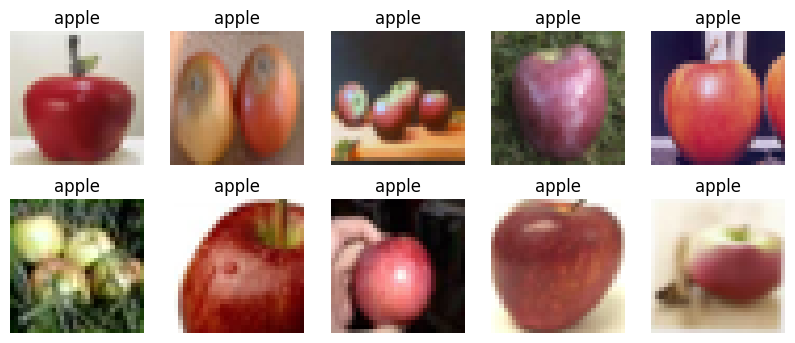

In [5]:
sample_images=[]
sample_labels=[]
sample_num=10
for x,y in trainset:
    if sample_num>0:
        sample_num-=1
        sample_images.append(x)
        sample_labels.append(y)
sample_images=torch.stack(sample_images)
sample_labels=torch.tensor(sample_labels)
imshow_grid(sample_images,sample_labels, n=2, m=5, classes=class_names, sampling=True, normalize_factor=((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) )

### Testset

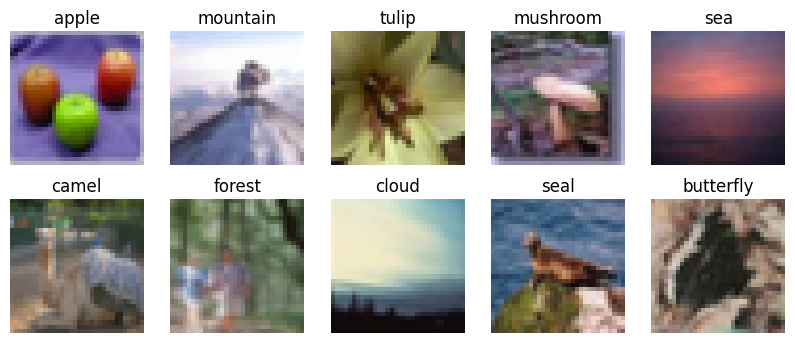

In [6]:
sample_images=[]
sample_labels=[]
sample_num=10
for x,y in testset:
    if sample_num>0:
        sample_num-=1
        sample_images.append(x)
        sample_labels.append(y)
sample_images=torch.stack(sample_images)
sample_labels=torch.tensor(sample_labels)
imshow_grid(sample_images,sample_labels, n=2, m=5, classes=class_names, sampling=True, normalize_factor=((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) )

### Frequency Distribution

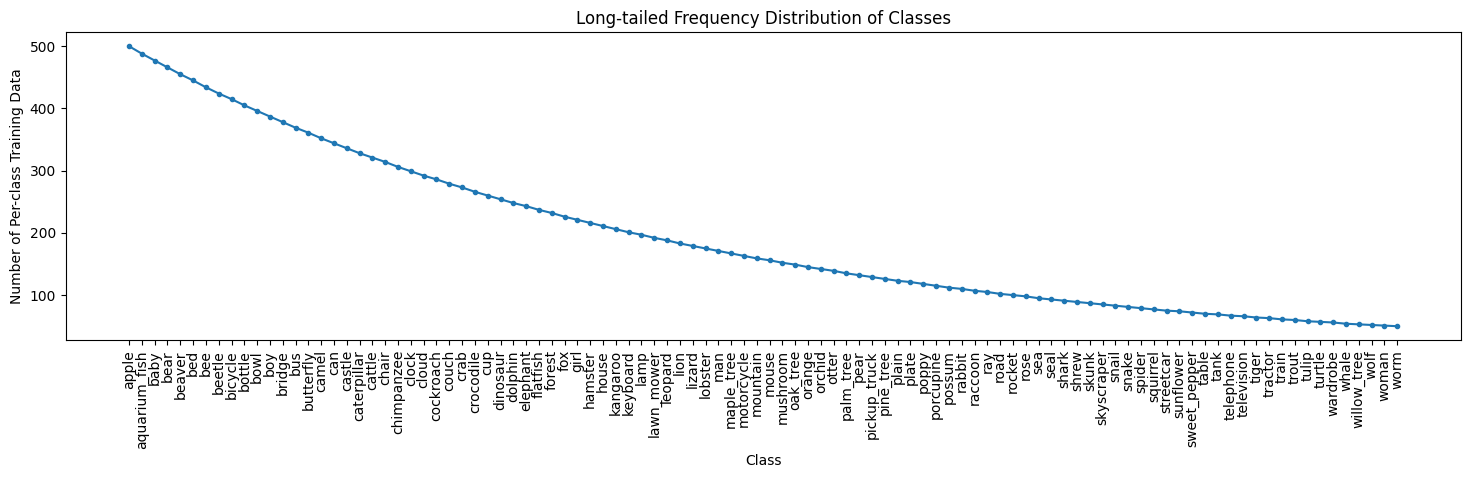

In [7]:
fig,ax=plt.subplots(1,1,figsize=(18,4))
ax.plot(class_names,img_num_per_cls,'.-')
# display(classes,img_num_per_cls)
ax.set_title('Long-tailed Frequency Distribution of Classes')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Per-class Training Data')
plt.xticks(rotation=90)
plt.show()

# Train Model

## Train Function

In [7]:
def record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs:list[int],save_folder,save_name):

    records = []
    max_epochs=max(epochs)
    print(f"Start training {save_name}...")
    for epoch in range(1,max_epochs+1):
        model.train()
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            train_loss = loss_fn(y_pred, y)
            
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print(f'<<Epoch {epoch}>> \ntrain_loss = {train_loss.item()}')

        classes_num=y_pred.size(1)

        correct_perclass = torch.zeros(classes_num,device=device)
        total_perclass = torch.zeros(classes_num,device=device)
        model.eval()
        with torch.no_grad():
            for x, y in testloader:

                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                test_loss = loss_fn(y_pred, y)
                
                _, predicted = torch.max(y_pred, 1)
                for i in range(classes_num):
                    total_perclass[i]+=(y==i).sum() 
                    correct_perclass[i]+=((predicted==i) & (y==i)).sum()
        scheduler.step(test_loss)
        acc_perclass=correct_perclass/total_perclass
        accuracy=correct_perclass.sum()/total_perclass.sum()
        print(f'test_loss = {test_loss.item()} \nAccuracy on the test set: {accuracy:.4f}')

        new_record = {
            'Epoch': epoch,
            'TrainLoss': train_loss.item(),
            'TestLoss': test_loss.item(),
            'Accuracy': accuracy.item(),
            **{f"Class{i} Accuracy": acc_perclass[i].item() for i in range(classes_num)}
        }
        records.append(new_record)
        
        if epoch in epochs:
            torch.save(model.state_dict(), f'{save_folder}/{save_name}_{epoch}ep.pt')
        columns = ["Epoch", "TrainLoss", "TestLoss", "Accuracy"] + [f"Class{i} Accuracy" for i in range(classes_num)]
        record_df = pd.DataFrame(records,columns=columns)
        record_df.to_csv(f'{save_folder}/{save_name}_{max_epochs}ep.csv',index=False)

## ---

## SmallVGG (naive)

In [41]:
class SmallVGG(torch.nn.Module):
    def __init__(self):
        super(SmallVGG, self).__init__()
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=3, padding=1), torch.nn.GroupNorm(2, 64), torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, padding=1), torch.nn.GroupNorm(4, 64), torch.nn.ReLU(),
            torch.nn.Dropout(0.25),  # 64,32,32

            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1), torch.nn.GroupNorm(8, 128), torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size=3, padding=1), torch.nn.GroupNorm(8, 128), torch.nn.ReLU(),
            torch.nn.Dropout(0.25), # 128,32,32

            torch.nn.Conv2d(128, 256, kernel_size=3, padding=1), torch.nn.GroupNorm(8, 256), torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1), torch.nn.GroupNorm(8, 256), torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), torch.nn.Dropout(0.25),  # 256,16,16

            torch.nn.Conv2d(256, 512, kernel_size=3, padding=1), torch.nn.GroupNorm(8, 512), torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, kernel_size=3, padding=1), torch.nn.GroupNorm(8, 512), torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),  # 512,8,8

            torch.nn.Conv2d(512, 1024, kernel_size=3, padding=1), torch.nn.GroupNorm(8, 1024), torch.nn.ReLU(),
            torch.nn.Conv2d(1024, 1024, kernel_size=3, padding=1), torch.nn.GroupNorm(8, 1024), torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)  # 1024,4,4
        )

        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(1024 * 4 * 4, 2048), torch.nn.GroupNorm(32, 2048), torch.nn.ReLU(),
            torch.nn.Dropout(0.5),  # Add Dropout here
            torch.nn.Linear(2048, 100)  # Output layer (100 classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)
        return x




In [67]:
model = SmallVGG().to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=None)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=32,isAugment=False,isClone=False)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=range(50,301,50),save_folder="./cifar100_models",save_name="SmallVGG_naive")

Start training SmallVGG_naive...
<<Epoch 1>> 
train_loss = 4.319694995880127
test_loss = 4.771178245544434 
Accuracy on the test set: 0.0300
<<Epoch 2>> 
train_loss = 4.341775417327881
test_loss = 4.714927673339844 
Accuracy on the test set: 0.0475
<<Epoch 3>> 
train_loss = 4.158223628997803
test_loss = 4.312478065490723 
Accuracy on the test set: 0.0733
<<Epoch 4>> 
train_loss = 3.871981382369995
test_loss = 4.360805511474609 
Accuracy on the test set: 0.0904
<<Epoch 5>> 
train_loss = 3.5639445781707764
test_loss = 4.258903503417969 
Accuracy on the test set: 0.1234
<<Epoch 6>> 
train_loss = 3.354485511779785
test_loss = 4.249395847320557 
Accuracy on the test set: 0.1402
<<Epoch 7>> 
train_loss = 3.4444024562835693
test_loss = 3.921693801879883 
Accuracy on the test set: 0.1559
<<Epoch 8>> 
train_loss = 3.1116371154785156
test_loss = 4.113399505615234 
Accuracy on the test set: 0.1572
<<Epoch 9>> 
train_loss = 2.9798245429992676
test_loss = 4.084738731384277 
Accuracy on the test set

## SmallVGG (clone)

In [11]:
model = SmallVGG().to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=None)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=32,isAugment=False,isClone=True)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=range(50,301,50),save_folder="./cifar100_models",save_name="SmallVGG_clone")

Start training SmallVGG_clone...


KeyboardInterrupt: 

## SmallVGG (aug)

In [81]:
model = SmallVGG().to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=None)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=32,isAugment=True,isClone=False)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=range(50,301,50),save_folder="./cifar100_models",save_name="SmallVGG_aug")

Start training SmallVGG_aug...
<<Epoch 1>> 
train_loss = 4.173917770385742
test_loss = 4.83983039855957 
Accuracy on the test set: 0.0323
<<Epoch 2>> 
train_loss = 3.9979701042175293
test_loss = 4.578288555145264 
Accuracy on the test set: 0.0491
<<Epoch 3>> 
train_loss = 4.165420055389404
test_loss = 4.5638813972473145 
Accuracy on the test set: 0.0643
<<Epoch 4>> 
train_loss = 3.670321226119995
test_loss = 4.505278587341309 
Accuracy on the test set: 0.0821
<<Epoch 5>> 
train_loss = 3.88262677192688
test_loss = 4.387459754943848 
Accuracy on the test set: 0.0917
<<Epoch 6>> 
train_loss = 3.644440174102783
test_loss = 4.271742820739746 
Accuracy on the test set: 0.0952
<<Epoch 7>> 
train_loss = 3.60951566696167
test_loss = 4.358304023742676 
Accuracy on the test set: 0.1045
<<Epoch 8>> 
train_loss = 3.659235715866089
test_loss = 4.141268730163574 
Accuracy on the test set: 0.1110
<<Epoch 9>> 
train_loss = 4.054662227630615
test_loss = 3.961195707321167 
Accuracy on the test set: 0.125

## SmallVGG (wd)

In [ ]:
model = SmallVGG().to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=None)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=32,isAugment=False,isClone=False)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=range(50,301,50),save_folder="./cifar100_models",save_name="SmallVGG_wd")

## SmallVGG (pcw)

In [ ]:
model = SmallVGG().to(device)

perclass_weights=1.0/torch.tensor(img_num_per_cls,dtype=torch.float,device=device)
perclass_weights=perclass_weights/perclass_weights.sum()

loss_fn = torch.nn.CrossEntropyLoss(weight=perclass_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=32,isAugment=False,isClone=False)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=range(50,301,50),save_folder="./cifar100_models",save_name="SmallVGG_pcw")

## SMALLVGG (aug+wd+pcw)

In [43]:
model = SmallVGG().to(device)

perclass_weights=1.0/torch.tensor(img_num_per_cls,dtype=torch.float,device=device)
perclass_weights=perclass_weights/perclass_weights.sum()

loss_fn = torch.nn.CrossEntropyLoss(weight=perclass_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=32,isAugment=True,isClone=False)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=range(50,301,50),save_folder="./cifar100_models",save_name="SmallVGG_aug_wd_pcw")

Start training SmallVGG_aug_wd_pcw...
<<Epoch 1>> 
train_loss = 4.645103931427002
test_loss = 4.512078762054443 
Accuracy on the test set: 0.0167
<<Epoch 2>> 
train_loss = 4.400069236755371
test_loss = 4.811739444732666 
Accuracy on the test set: 0.0183
<<Epoch 3>> 
train_loss = 4.384868144989014
test_loss = 4.826012134552002 
Accuracy on the test set: 0.0214
<<Epoch 4>> 
train_loss = 4.442734241485596
test_loss = 4.845884323120117 
Accuracy on the test set: 0.0209
<<Epoch 5>> 
train_loss = 4.515124797821045
test_loss = 4.700021266937256 
Accuracy on the test set: 0.0358
<<Epoch 6>> 
train_loss = 4.363468170166016
test_loss = 4.67772102355957 
Accuracy on the test set: 0.0382
<<Epoch 7>> 
train_loss = 4.5080695152282715
test_loss = 4.820957183837891 
Accuracy on the test set: 0.0314
<<Epoch 8>> 
train_loss = 4.61394739151001
test_loss = 4.700008869171143 
Accuracy on the test set: 0.0438
<<Epoch 9>> 
train_loss = 4.436002731323242
test_loss = 4.668421745300293 
Accuracy on the test set

KeyboardInterrupt: 

## ---

## ResNet32 (naive)

In [37]:
class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.nn.functional.relu(out)
        return out

class ResNet(torch.nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = torch.nn.Linear(64*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.functional.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet32():
    return ResNet(BasicBlock, [5, 5, 5], num_classes=100)



In [10]:
model = ResNet32().to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=None)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=32,isAugment=False,isClone=False)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=range(50,301,50),save_folder="./cifar100_models",save_name="ResNet32_naive")

Start training ResNet32_naive...
<<Epoch 1>> 
train_loss = 3.7483842372894287
test_loss = 4.339942932128906 
Accuracy on the test set: 0.0559
<<Epoch 2>> 
train_loss = 3.457180976867676
test_loss = 4.302721977233887 
Accuracy on the test set: 0.0940
<<Epoch 3>> 
train_loss = 3.433131456375122
test_loss = 4.046127796173096 
Accuracy on the test set: 0.1118
<<Epoch 4>> 
train_loss = 2.8737995624542236
test_loss = 3.4722137451171875 
Accuracy on the test set: 0.1718
<<Epoch 5>> 
train_loss = 3.232739210128784
test_loss = 3.2942728996276855 
Accuracy on the test set: 0.2115
<<Epoch 6>> 
train_loss = 2.3706307411193848
test_loss = 3.4671826362609863 
Accuracy on the test set: 0.2268
<<Epoch 7>> 
train_loss = 2.4449384212493896
test_loss = 3.0988640785217285 
Accuracy on the test set: 0.2499
<<Epoch 8>> 
train_loss = 2.16941499710083
test_loss = 3.1272099018096924 
Accuracy on the test set: 0.2776
<<Epoch 9>> 
train_loss = 2.375140905380249
test_loss = 3.3029701709747314 
Accuracy on the tes

## ResNet32 (clone)

In [13]:
model = ResNet32().to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=None)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=32,isAugment=False,isClone=True)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=range(50,301,50),save_folder="./cifar100_models",save_name="ResNet32_clone")

Start training ResNet32_clone...


KeyboardInterrupt: 

## ResNet32 (aug)

In [14]:
model = ResNet32().to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=None)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=32,isAugment=True,isClone=False)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=range(50,301,50),save_folder="./cifar100_models",save_name="ResNet32_aug")

Start training ResNet32_aug...
<<Epoch 1>> 
train_loss = 3.78755521774292
test_loss = 4.3496599197387695 
Accuracy on the test set: 0.0394
<<Epoch 2>> 
train_loss = 4.070558547973633
test_loss = 4.012846946716309 
Accuracy on the test set: 0.0771
<<Epoch 3>> 
train_loss = 3.38525128364563
test_loss = 3.8967490196228027 
Accuracy on the test set: 0.1144
<<Epoch 4>> 
train_loss = 3.4242327213287354
test_loss = 3.797431707382202 
Accuracy on the test set: 0.1405
<<Epoch 5>> 
train_loss = 2.996286392211914
test_loss = 3.492373466491699 
Accuracy on the test set: 0.1715
<<Epoch 6>> 
train_loss = 3.1586155891418457
test_loss = 3.8803043365478516 
Accuracy on the test set: 0.1905
<<Epoch 7>> 
train_loss = 2.544271230697632
test_loss = 3.3853492736816406 
Accuracy on the test set: 0.2479
<<Epoch 8>> 
train_loss = 2.506608247756958
test_loss = 3.079350233078003 
Accuracy on the test set: 0.2573
<<Epoch 9>> 
train_loss = 2.0849528312683105
test_loss = 2.9500479698181152 
Accuracy on the test set

## ResNet32 (wd)

In [15]:
model = ResNet32().to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=None)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=32,isAugment=False,isClone=False)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=range(50,301,50),save_folder="./cifar100_models",save_name="ResNet32_wd")

Start training ResNet32_wd...
<<Epoch 1>> 
train_loss = 4.1701812744140625
test_loss = 4.359355926513672 
Accuracy on the test set: 0.0573
<<Epoch 2>> 
train_loss = 3.6123437881469727
test_loss = 4.365159511566162 
Accuracy on the test set: 0.0766
<<Epoch 3>> 
train_loss = 3.6613314151763916
test_loss = 3.6811623573303223 
Accuracy on the test set: 0.1004
<<Epoch 4>> 
train_loss = 3.216844081878662
test_loss = 3.904914617538452 
Accuracy on the test set: 0.1230
<<Epoch 5>> 
train_loss = 3.1465566158294678
test_loss = 3.4118635654449463 
Accuracy on the test set: 0.1519
<<Epoch 6>> 
train_loss = 2.739121913909912
test_loss = 3.430666923522949 
Accuracy on the test set: 0.1731
<<Epoch 7>> 
train_loss = 3.3030753135681152
test_loss = 3.5675783157348633 
Accuracy on the test set: 0.1785
<<Epoch 8>> 
train_loss = 2.5112760066986084
test_loss = 3.649820327758789 
Accuracy on the test set: 0.1993
<<Epoch 9>> 
train_loss = 2.7085747718811035
test_loss = 2.993598699569702 
Accuracy on the test 

## ResNet32 (pcw)

In [36]:
model = ResNet32().to(device)

perclass_weights=1.0/torch.tensor(img_num_per_cls,dtype=torch.float,device=device)
perclass_weights=perclass_weights/perclass_weights.sum()

loss_fn = torch.nn.CrossEntropyLoss(weight=perclass_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=32,isAugment=False,isClone=False)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=range(50,301,50),save_folder="./cifar100_models",save_name="ResNet32_pcw")

Start training ResNet32_pcw...
<<Epoch 1>> 
train_loss = 4.0876851081848145
test_loss = 3.9867069721221924 
Accuracy on the test set: 0.0448
<<Epoch 2>> 
train_loss = 3.893967866897583
test_loss = 3.9799718856811523 
Accuracy on the test set: 0.0538
<<Epoch 3>> 
train_loss = 3.731687068939209
test_loss = 3.8728396892547607 
Accuracy on the test set: 0.0863
<<Epoch 4>> 
train_loss = 3.1952130794525146
test_loss = 3.579418897628784 
Accuracy on the test set: 0.1279
<<Epoch 5>> 
train_loss = 3.595266103744507
test_loss = 3.502875804901123 
Accuracy on the test set: 0.1744
<<Epoch 6>> 
train_loss = 3.4802050590515137
test_loss = 3.3089957237243652 
Accuracy on the test set: 0.1894
<<Epoch 7>> 
train_loss = 2.3857457637786865
test_loss = 3.2509031295776367 
Accuracy on the test set: 0.2251
<<Epoch 8>> 
train_loss = 2.8800735473632812
test_loss = 3.109602689743042 
Accuracy on the test set: 0.2424
<<Epoch 9>> 
train_loss = 2.6929264068603516
test_loss = 3.023629903793335 
Accuracy on the tes

## ResNet32 (aug+wd+pcw) 

In [39]:
model = ResNet32().to(device)

perclass_weights=1.0/torch.tensor(img_num_per_cls,dtype=torch.float,device=device)
perclass_weights=perclass_weights/perclass_weights.sum()

loss_fn = torch.nn.CrossEntropyLoss(weight=perclass_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=32,isAugment=True,isClone=False)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=range(50,301,50),save_folder="./cifar100_models",save_name="ResNet32_aug_wd_pcw")

Start training ResNet32_aug_wd_pcw...
<<Epoch 1>> 
train_loss = 4.433117866516113
test_loss = 4.533121109008789 
Accuracy on the test set: 0.0190
<<Epoch 2>> 
train_loss = 4.239947319030762
test_loss = 3.983151912689209 
Accuracy on the test set: 0.0709
<<Epoch 3>> 
train_loss = 3.7690224647521973
test_loss = 3.6482536792755127 
Accuracy on the test set: 0.0897
<<Epoch 4>> 
train_loss = 3.5479469299316406
test_loss = 3.532761335372925 
Accuracy on the test set: 0.1142
<<Epoch 5>> 
train_loss = 3.1956748962402344
test_loss = 3.6311147212982178 
Accuracy on the test set: 0.1298
<<Epoch 6>> 
train_loss = 3.7138144969940186
test_loss = 3.1973142623901367 
Accuracy on the test set: 0.1376
<<Epoch 7>> 
train_loss = 3.819528579711914
test_loss = 3.2804653644561768 
Accuracy on the test set: 0.1789
<<Epoch 8>> 
train_loss = 2.6945011615753174
test_loss = 3.066899299621582 
Accuracy on the test set: 0.1805
<<Epoch 9>> 
train_loss = 3.551443099975586
test_loss = 3.2129499912261963 
Accuracy on t

## ResNet32 (aug+wd+pcw+rf)

In [47]:
class BasicBlock_fusion(torch.nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock_fusion, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(self.expansion*planes)
            )

        # 残差融合机制：额外的残差分支
        self.fusion_conv1 = torch.nn.Conv2d(planes, planes, kernel_size=1, bias=False)
        self.fusion_bn1 = torch.nn.BatchNorm2d(planes)
        self.fusion_conv2 = torch.nn.Conv2d(planes, planes, kernel_size=1, bias=False)
        self.fusion_bn2 = torch.nn.BatchNorm2d(planes)

    def forward(self, x):
        out = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        residual = self.shortcut(x)
        out += residual

        # 融合机制：融合不同的残差信息
        fusion1 = torch.nn.functional.relu(self.fusion_bn1(self.fusion_conv1(residual)))
        fusion2 = torch.nn.functional.relu(self.fusion_bn2(self.fusion_conv2(out)))
        out = out+ fusion1 + fusion2

        out = torch.nn.functional.relu(out)
        return out

class ResNet_fusion(torch.nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(ResNet_fusion, self).__init__()
        self.in_planes = 16

        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = torch.nn.Linear(64*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.functional.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet32_fusion():
    return ResNet_fusion(BasicBlock_fusion, [5, 5, 5], num_classes=100)




In [48]:
model = ResNet32_fusion().to(device)

perclass_weights=1.0/torch.tensor(img_num_per_cls,dtype=torch.float,device=device)
perclass_weights=perclass_weights/perclass_weights.sum()

loss_fn = torch.nn.CrossEntropyLoss(weight=perclass_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=32,isAugment=True,isClone=False)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=range(50,301,50),save_folder="./cifar100_models",save_name="ResNet32_aug_wd_pcw_rf")

Start training ResNet32_aug_wd_pcw...
<<Epoch 1>> 
train_loss = 4.311276435852051
test_loss = 4.486850738525391 
Accuracy on the test set: 0.0227
<<Epoch 2>> 
train_loss = 4.136373043060303
test_loss = 4.2289204597473145 
Accuracy on the test set: 0.0455
<<Epoch 3>> 
train_loss = 4.380424499511719
test_loss = 3.7569820880889893 
Accuracy on the test set: 0.0659
<<Epoch 4>> 
train_loss = 3.8624517917633057
test_loss = 3.6914100646972656 
Accuracy on the test set: 0.0759
<<Epoch 5>> 
train_loss = 3.9021596908569336
test_loss = 3.783529043197632 
Accuracy on the test set: 0.0930
<<Epoch 6>> 
train_loss = 3.4533891677856445
test_loss = 3.724439859390259 
Accuracy on the test set: 0.1242
<<Epoch 7>> 
train_loss = 3.3649277687072754
test_loss = 3.347770929336548 
Accuracy on the test set: 0.1399
<<Epoch 8>> 
train_loss = 3.742830753326416
test_loss = 3.3945538997650146 
Accuracy on the test set: 0.1347
<<Epoch 9>> 
train_loss = 3.5298540592193604
test_loss = 3.472784996032715 
Accuracy on th

## ---

## SmallViT (naive)

In [80]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=100)
model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=None)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=224,isAugment=False,isClone=False)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=[25,50,75,100],save_folder="./cifar100_models",save_name='smallViT_aug_wd_pcw_rf')

Start training smallViT_naive...


KeyboardInterrupt: 

## SmallViT (clone)

In [ ]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=100)
model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=None)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=224,isAugment=False,isClone=True)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=[25,50,75,100],save_folder="./cifar100_models",save_name='smallViT_clone')

## SmallViT (aug)

In [ ]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=100)
model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=None)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=224,isAugment=True,isClone=False)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=[25,50,75,100],save_folder="./cifar100_models",save_name='smallViT_aug')

## SmallViT (wd)

In [ ]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=100)
model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=None)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=224,isAugment=False,isClone=False)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=[25,50,75,100],save_folder="./cifar100_models",save_name='smallViT_wd')

## SmallViT (pcw)

In [ ]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=100)
model = model.to(device)

perclass_weights=1.0/torch.tensor(img_num_per_cls,dtype=torch.float,device=device)
perclass_weights=perclass_weights/perclass_weights.sum()

loss_fn = torch.nn.CrossEntropyLoss(weight=perclass_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=224,isAugment=False,isClone=False)
record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=[25,50,75,100],save_folder="./cifar100_models",save_name='smallViT_naive')

## SmallViT (aug+wd+pcw)

In [16]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=100)
model = model.to(device)

perclass_weights=1.0/torch.tensor(img_num_per_cls,dtype=torch.float,device=device)
perclass_weights=perclass_weights/perclass_weights.sum()

loss_fn = torch.nn.CrossEntropyLoss(weight=perclass_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

load_cifar100(img_size=224,isAugment=True)


record_train(model,loss_fn,optimizer,scheduler,trainloader,testloader,epochs=[25,50,75,100],save_folder="./cifar100_models",save_name='smallViT_aug_wd_pcw')

Start training smallViT_aug_wd_pcw...
<<Epoch 1>> 
train_loss = 2.6441476345062256
test_loss = 2.9189674854278564 
Accuracy on the test set: 0.4900
<<Epoch 2>> 
train_loss = 1.2667986154556274
test_loss = 1.2826716899871826 
Accuracy on the test set: 0.7520
<<Epoch 3>> 
train_loss = 1.2013354301452637
test_loss = 0.9269984364509583 
Accuracy on the test set: 0.8110
<<Epoch 4>> 
train_loss = 0.5802571773529053
test_loss = 0.8279896974563599 
Accuracy on the test set: 0.8339
<<Epoch 5>> 
train_loss = 0.37725991010665894
test_loss = 0.7061070203781128 
Accuracy on the test set: 0.8477
<<Epoch 6>> 
train_loss = 0.6152506470680237
test_loss = 0.6994118094444275 
Accuracy on the test set: 0.8535
<<Epoch 7>> 
train_loss = 0.29241201281547546
test_loss = 0.758606493473053 
Accuracy on the test set: 0.8594
<<Epoch 8>> 
train_loss = 0.4933142364025116
test_loss = 0.6251619458198547 
Accuracy on the test set: 0.8661
<<Epoch 9>> 
train_loss = 0.22471478581428528
test_loss = 0.5950999855995178 
Acc

# Model Validaion

## Train Log Summary

In [33]:
def train_log_summary(record_file,classes_num,check_epoch:int,frequency_distribution:list[int]=None, class_names=None):

    df = pd.read_csv(record_file)
    fig, ax=plt.subplots(1, 2, figsize=(15, 6))
    
    ax[0].plot(df['Epoch'], df['Accuracy'], '-')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')

    ax[1].plot(df['Epoch'], df['TrainLoss'],'-', label='Train')
    ax[1].plot(df['Epoch'], df['TestLoss'],'-', label='Test')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    
    plt.show()

    fig2,ax2l=plt.subplots(1,1,figsize=(18,6))
    ax2l.bar(np.arange(classes_num), df.loc[check_epoch-1,"Class0 Accuracy":], color='orange', label=f'Epoch{check_epoch} Accuracy')
    # ax2.plot(np.arange(classes_num), df.loc[i-1,"Class0 Accuracy":],"o", label=f'Epoch{i} Accuracy')
    if frequency_distribution is not None:
        ax2r=ax2l.twinx()
        ax2r.plot(range(classes_num),frequency_distribution,'.-',label='Number of Per-class Training Data')
        # display(classes,img_num_per_cls)
    ax2l.legend()
    ax2l.set_title(f'Per-Class Accuracy (micro avg={round( df["Accuracy"][check_epoch-1],4) })')
    ax2l.set_xlabel('Class')
    ax2l.set_ylabel('Accuracy')
    ax2l.set_xticks(range(classes_num))
    ax2l.set_xticklabels(class_names,rotation=90)
    plt.show()

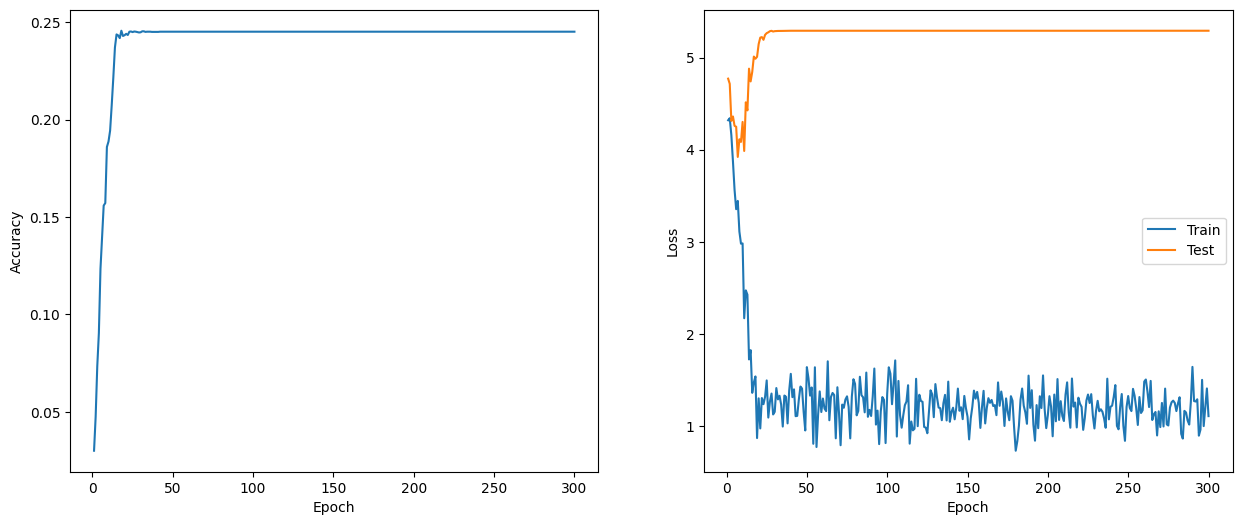

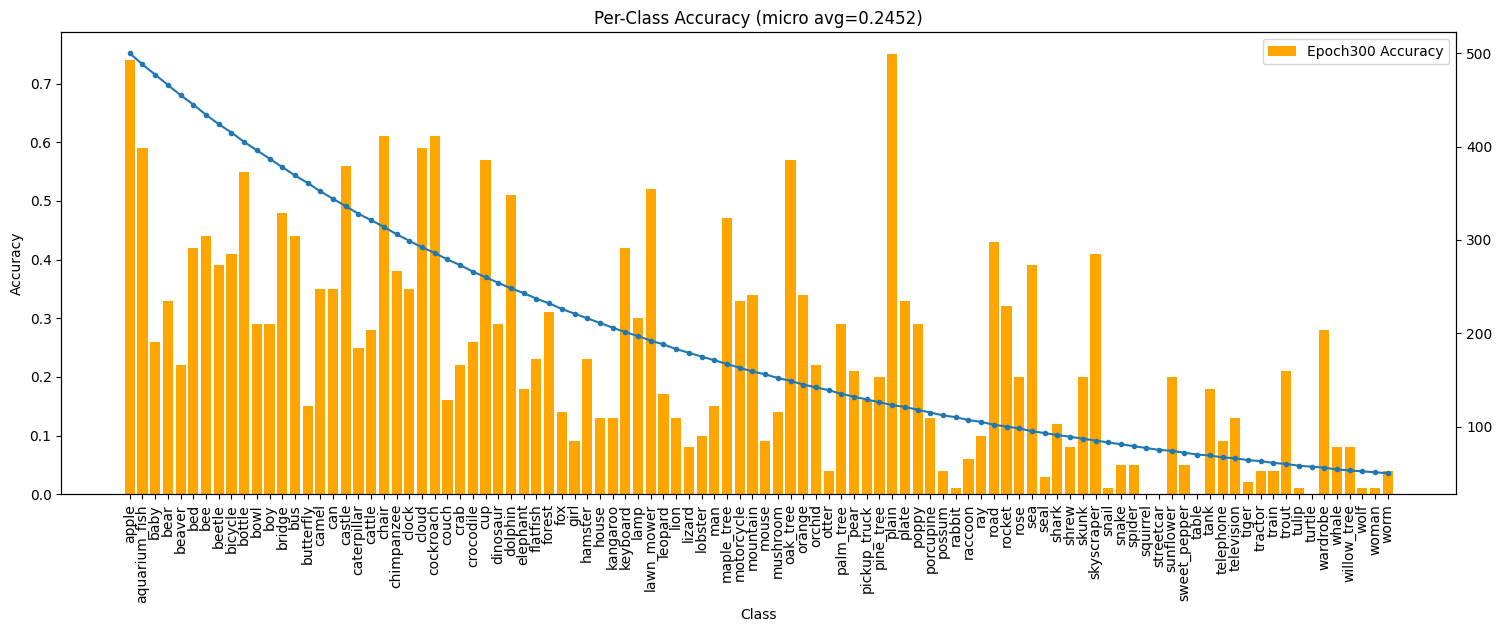

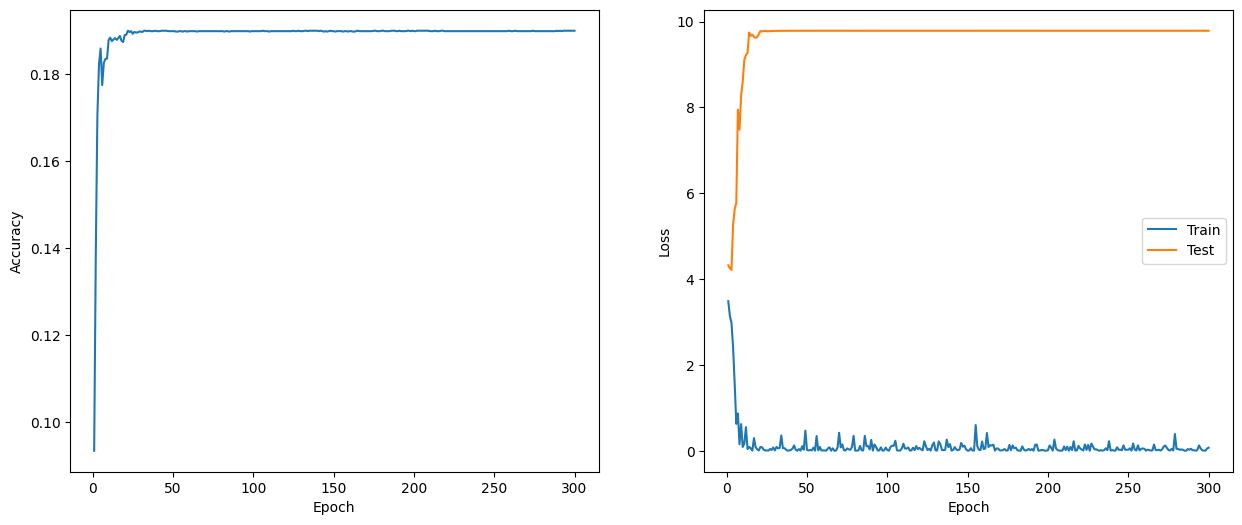

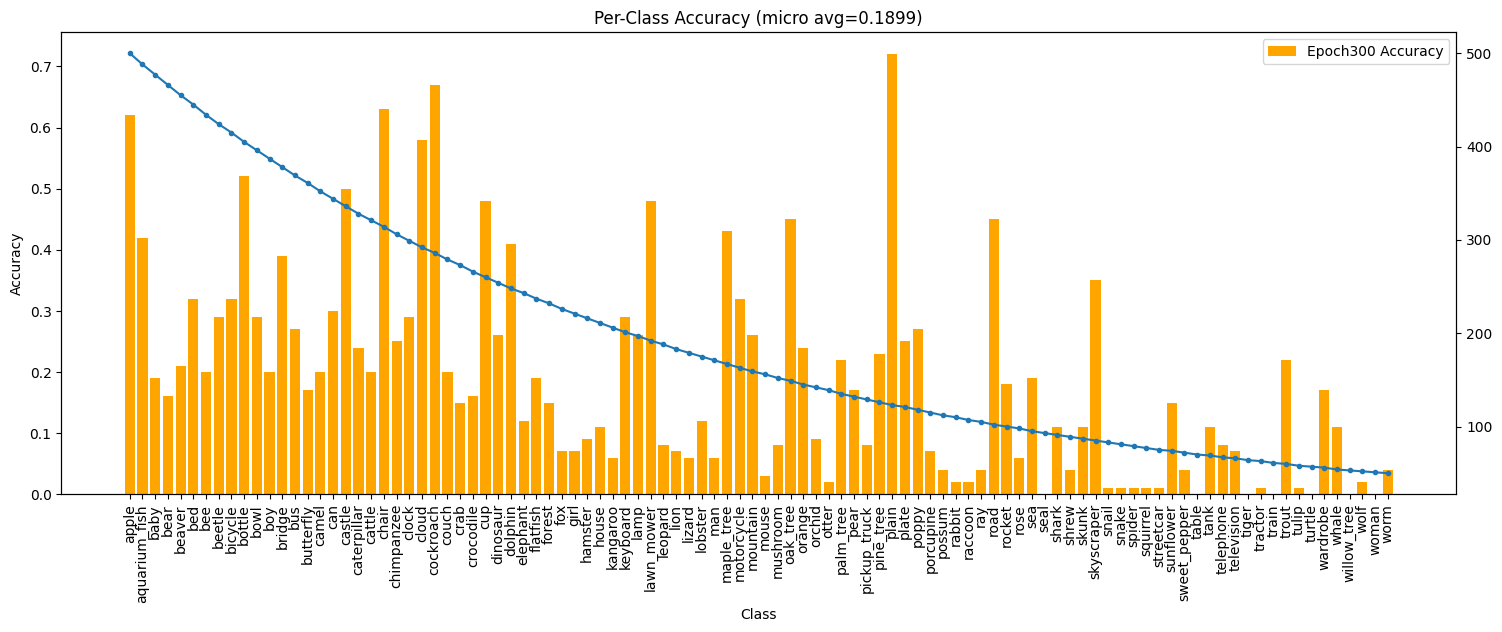

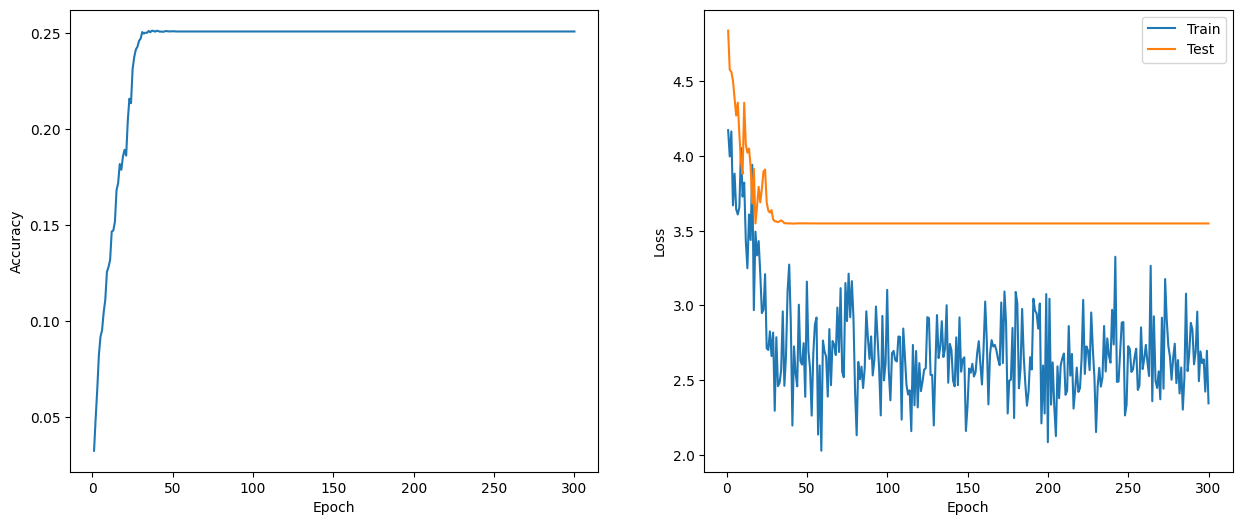

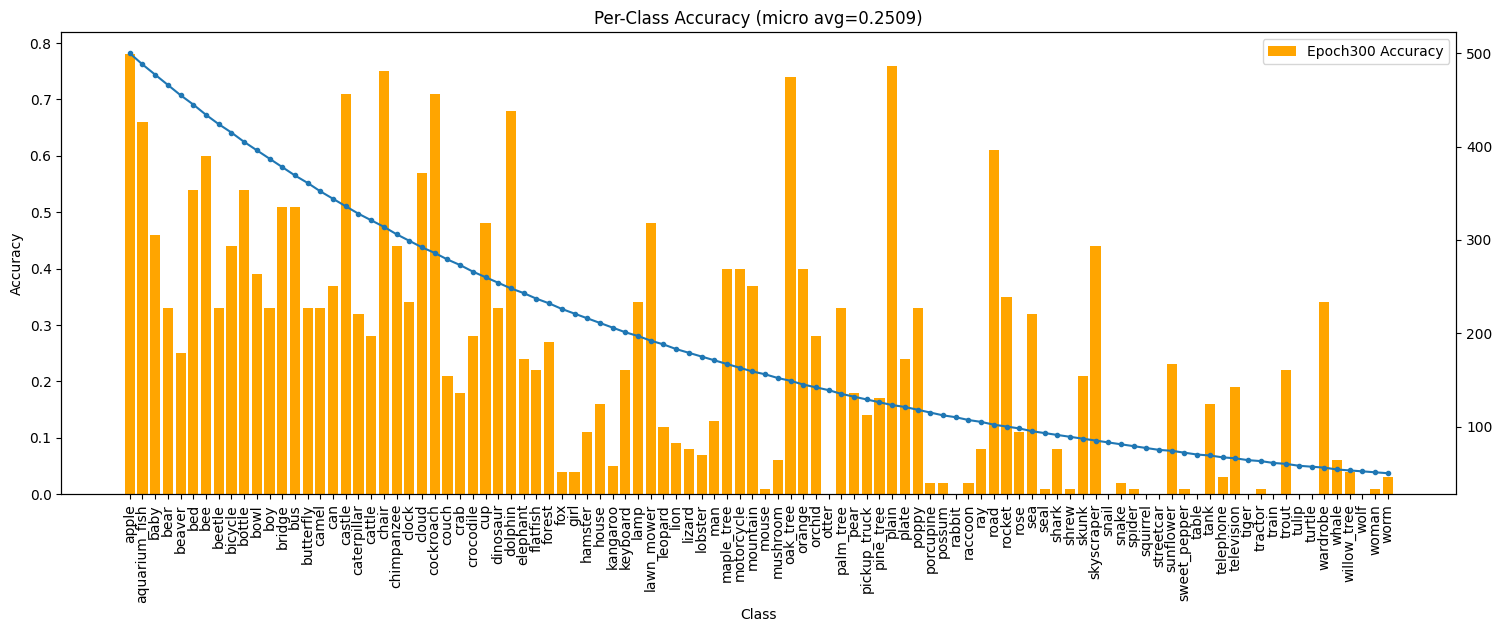

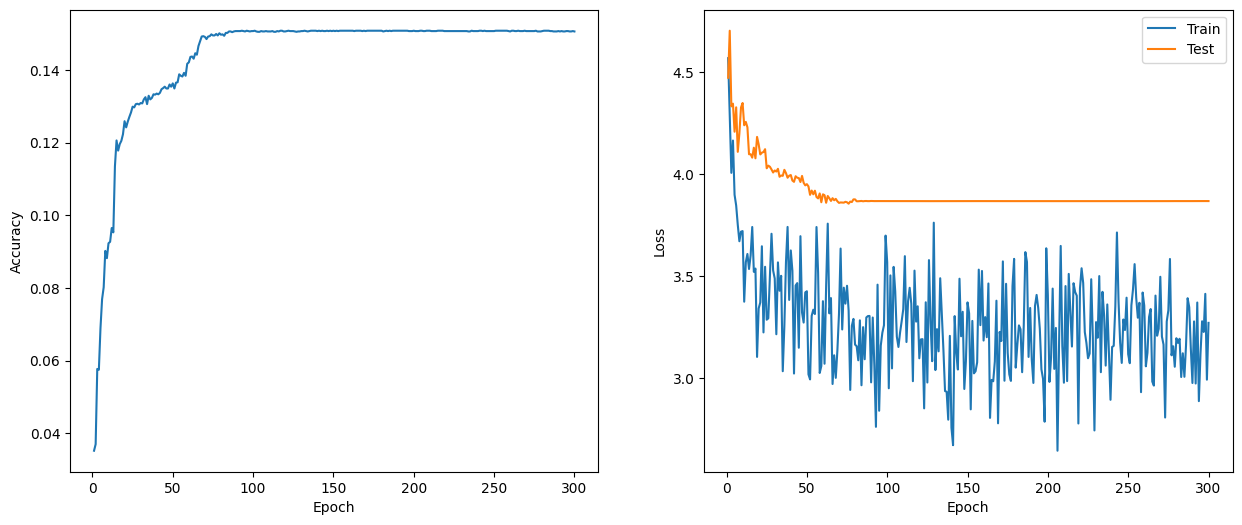

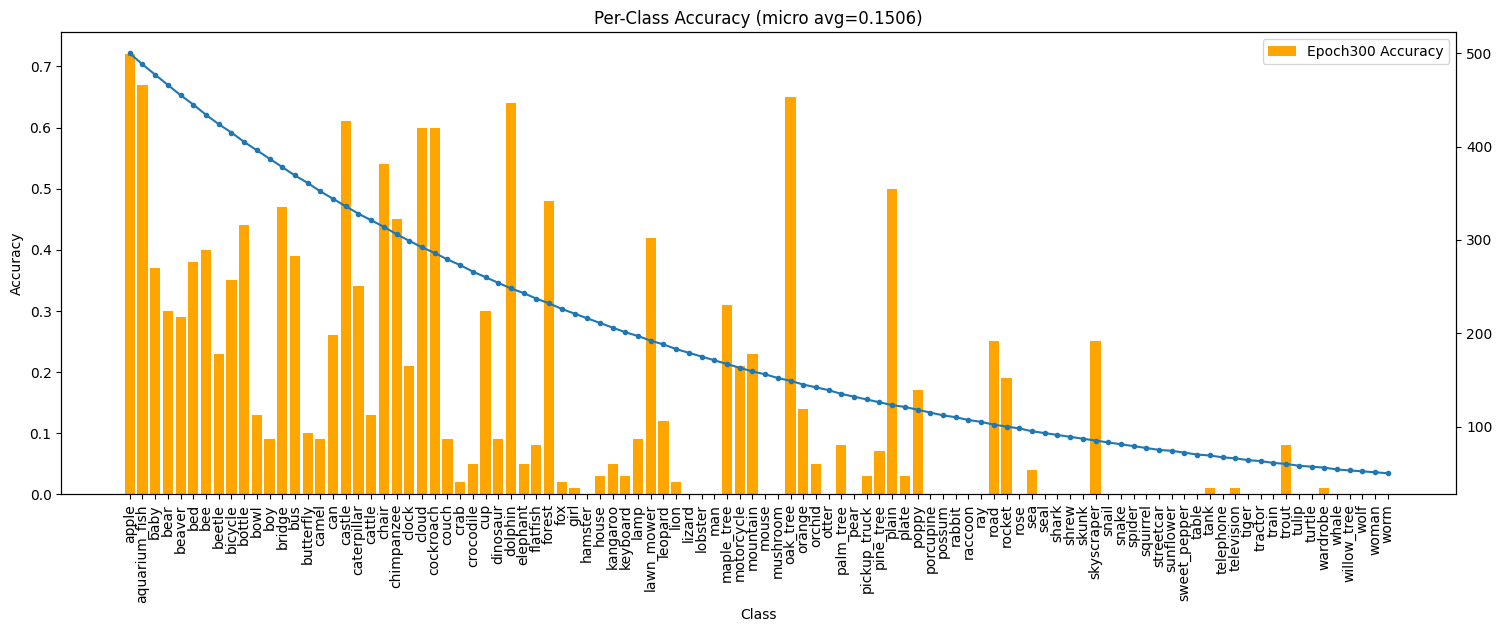

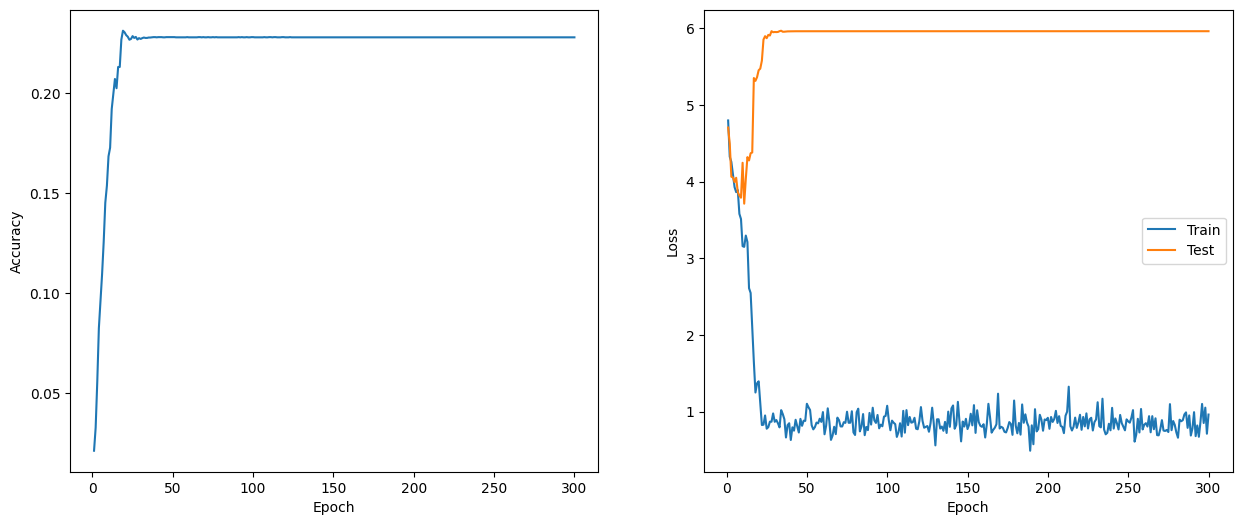

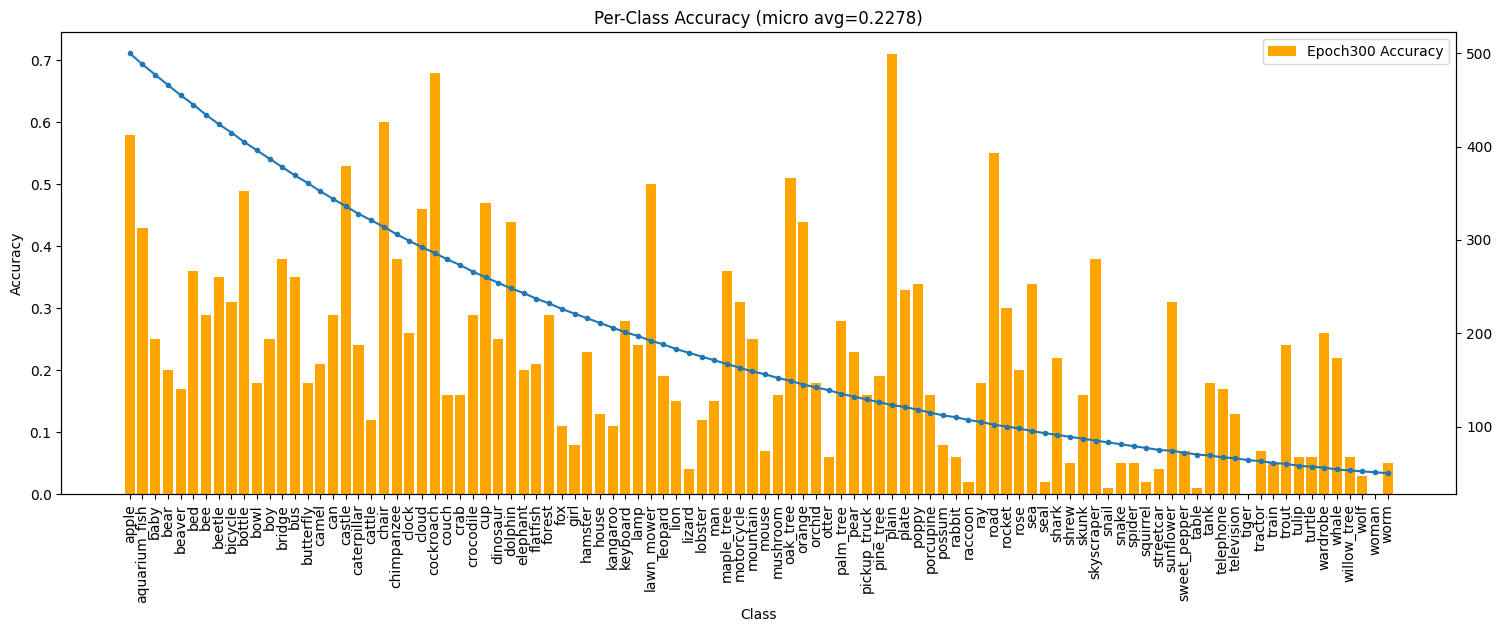

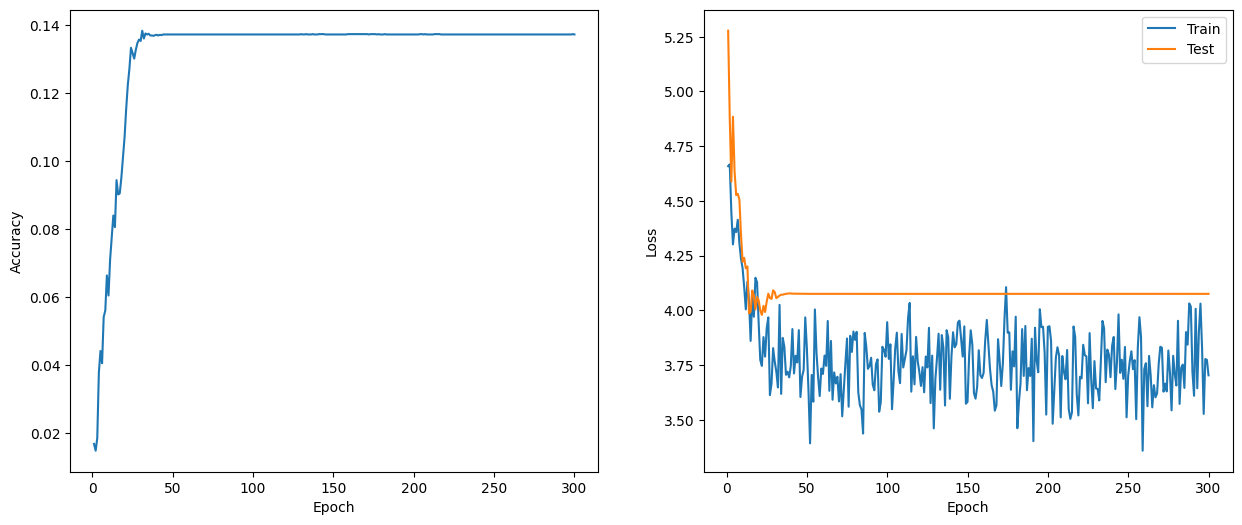

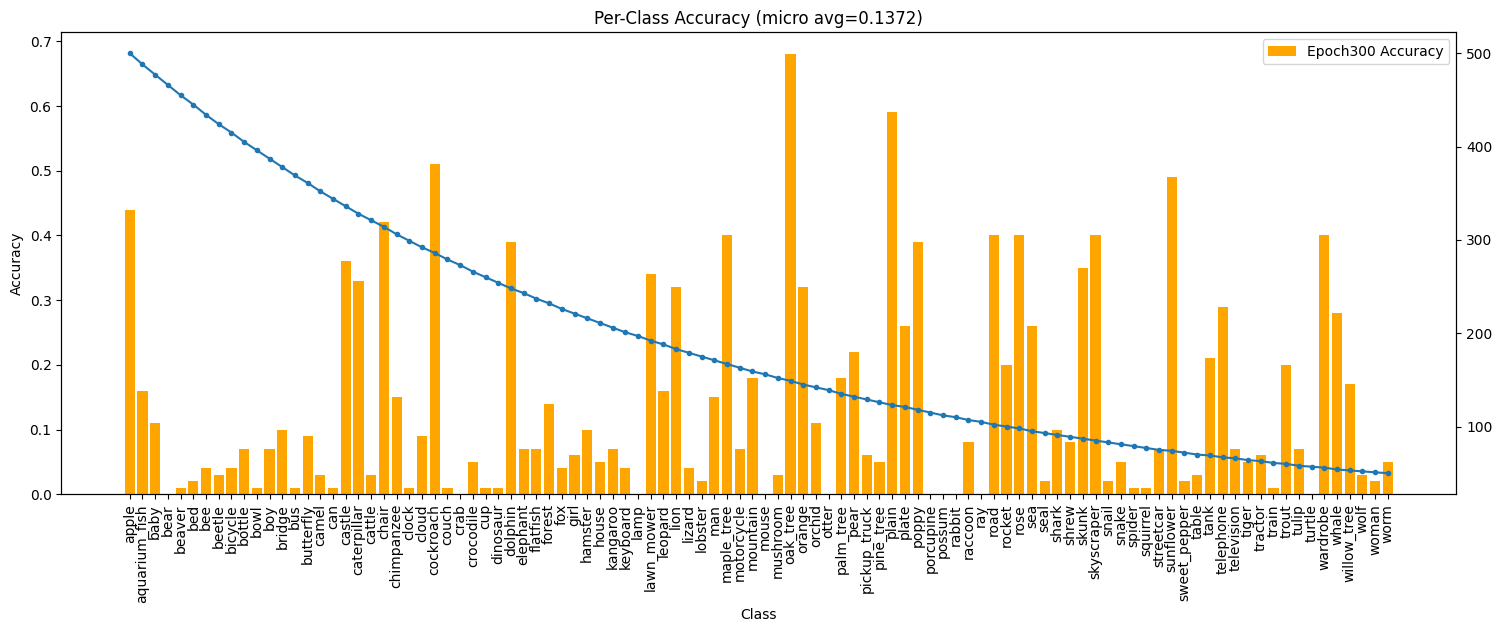

--------------------


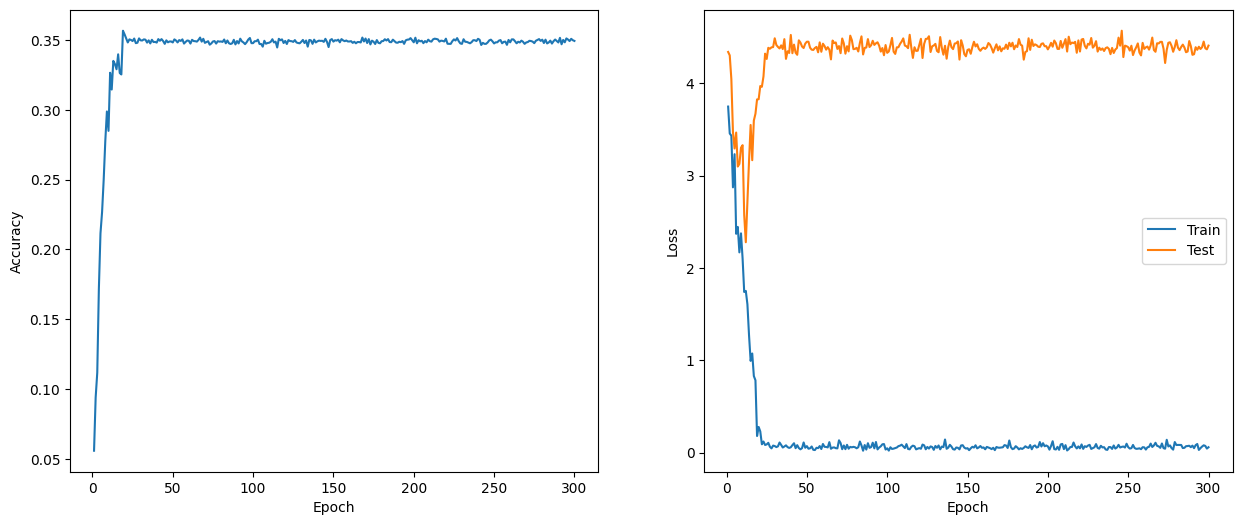

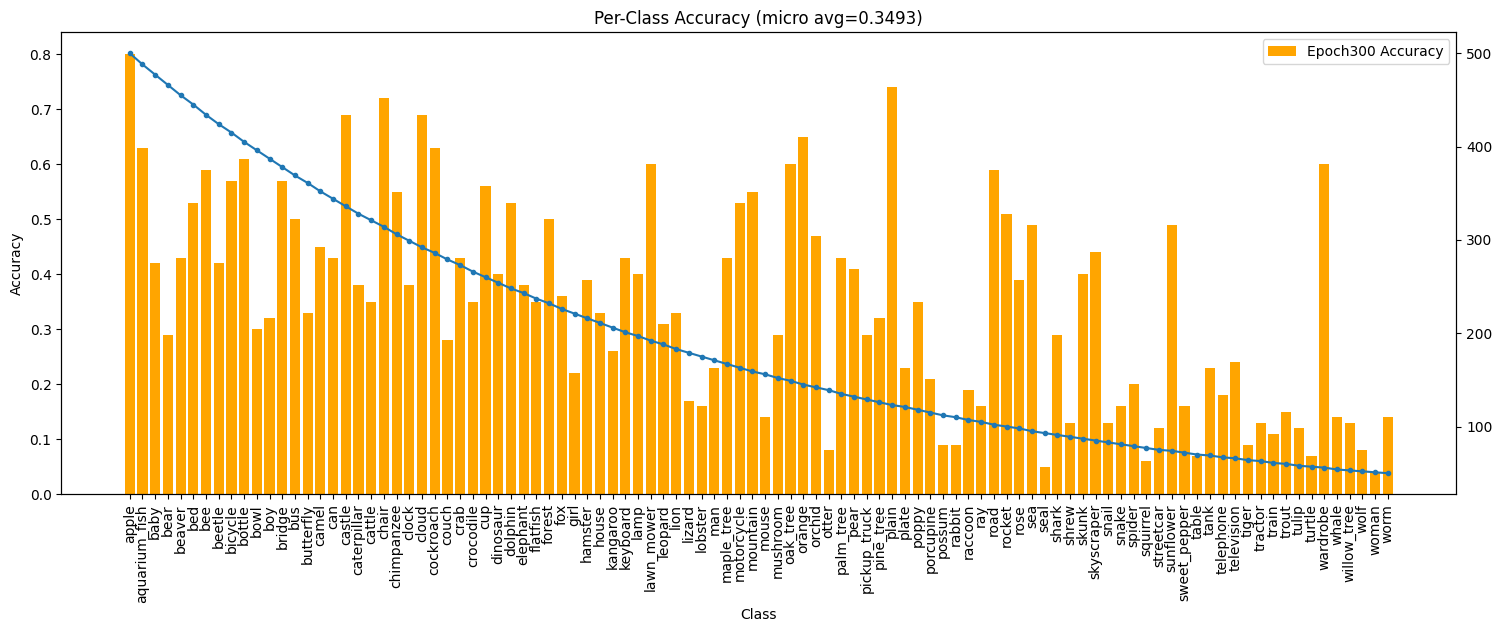

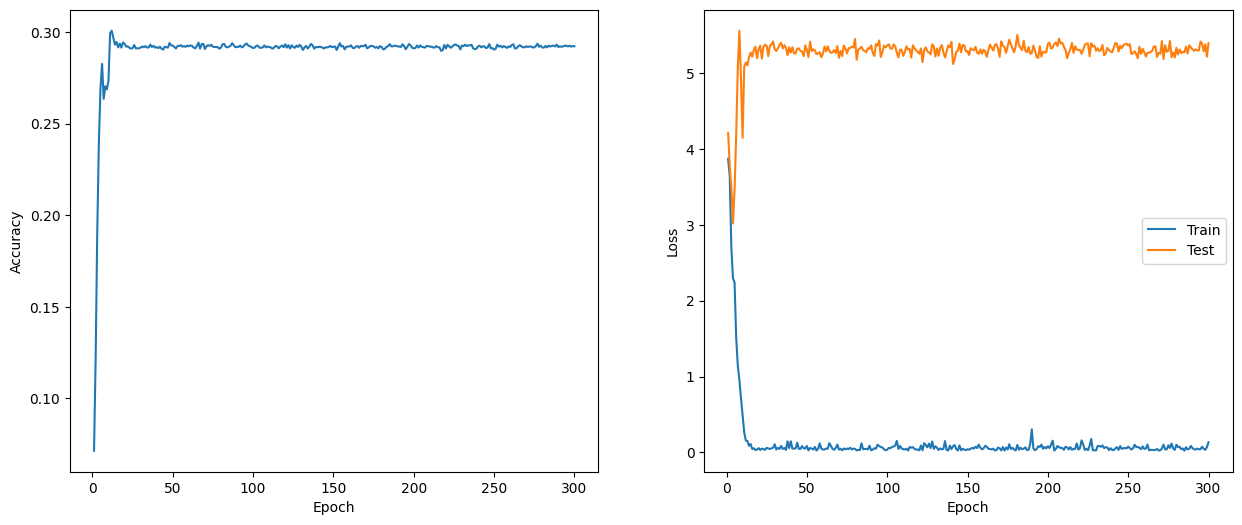

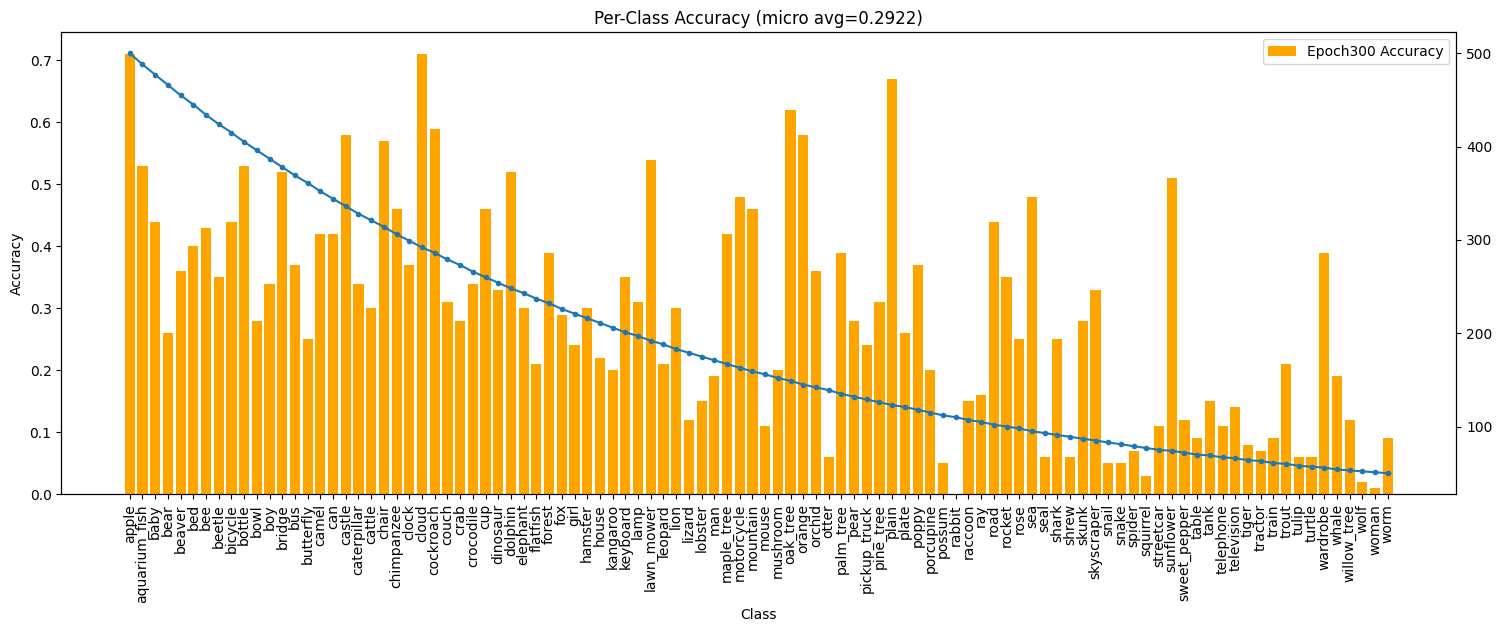

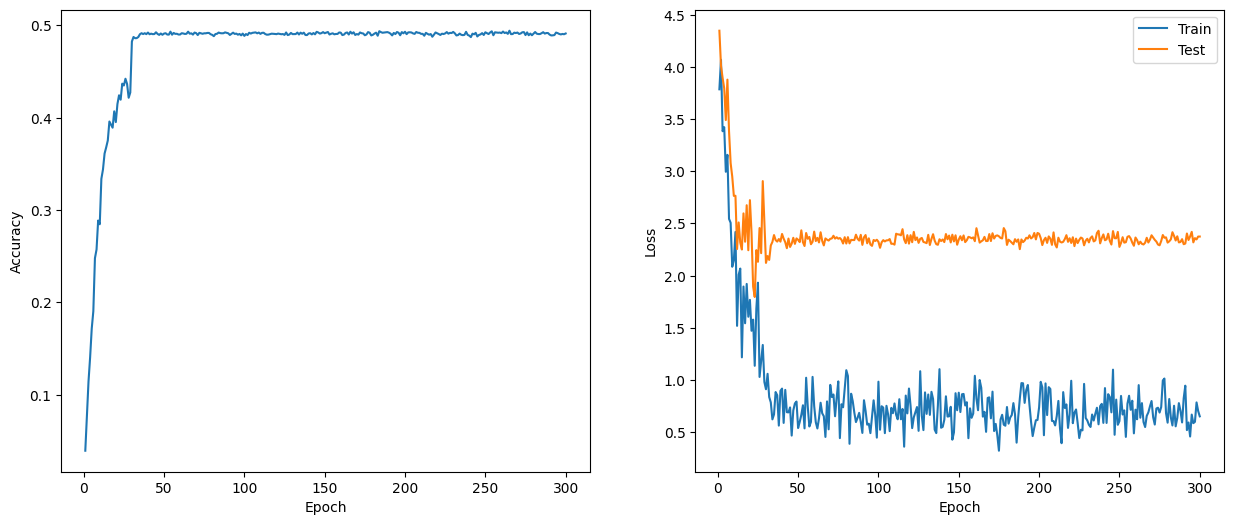

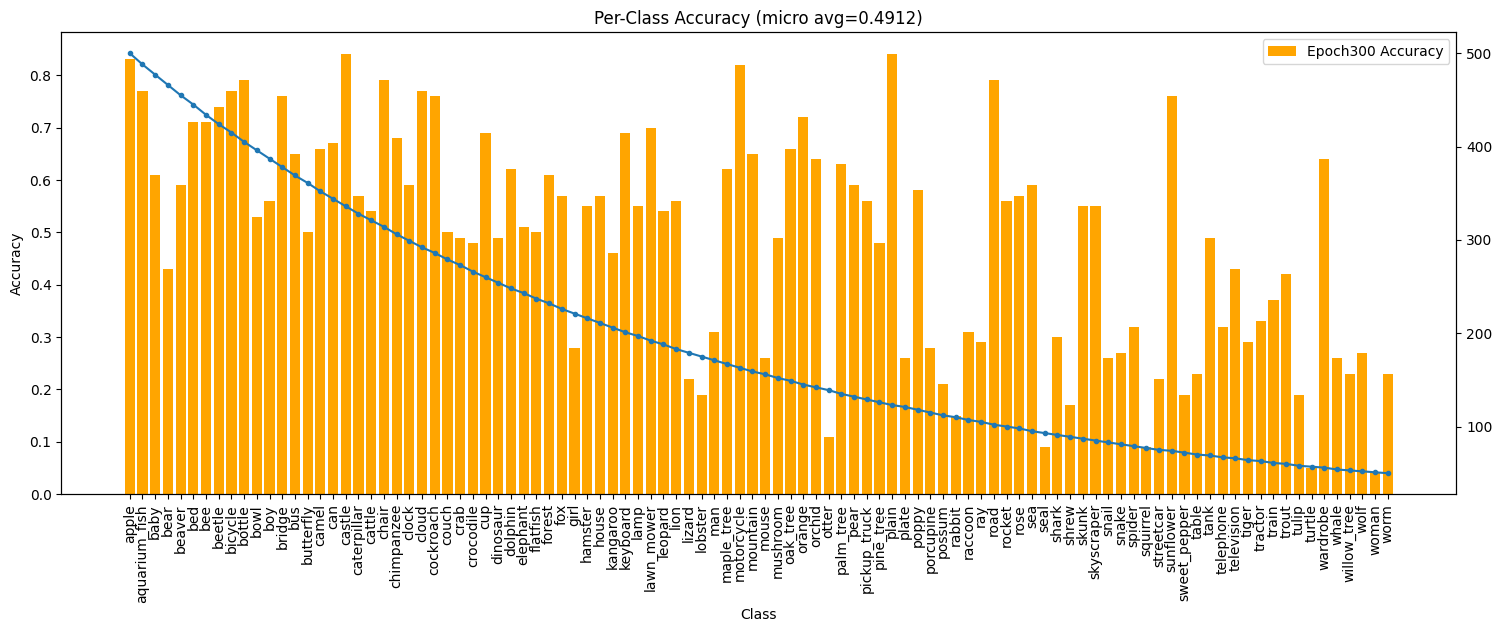

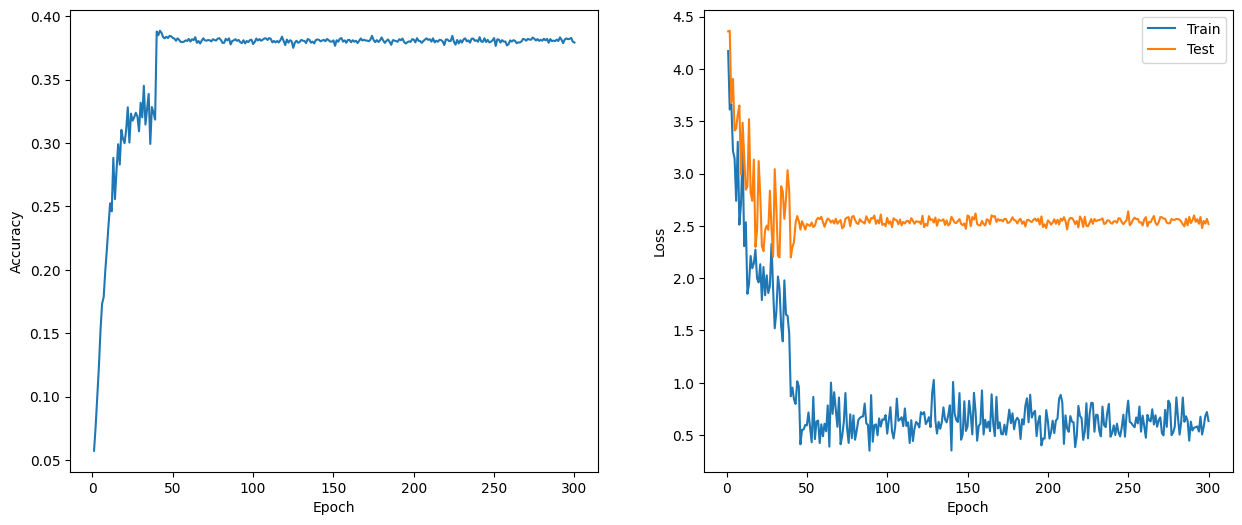

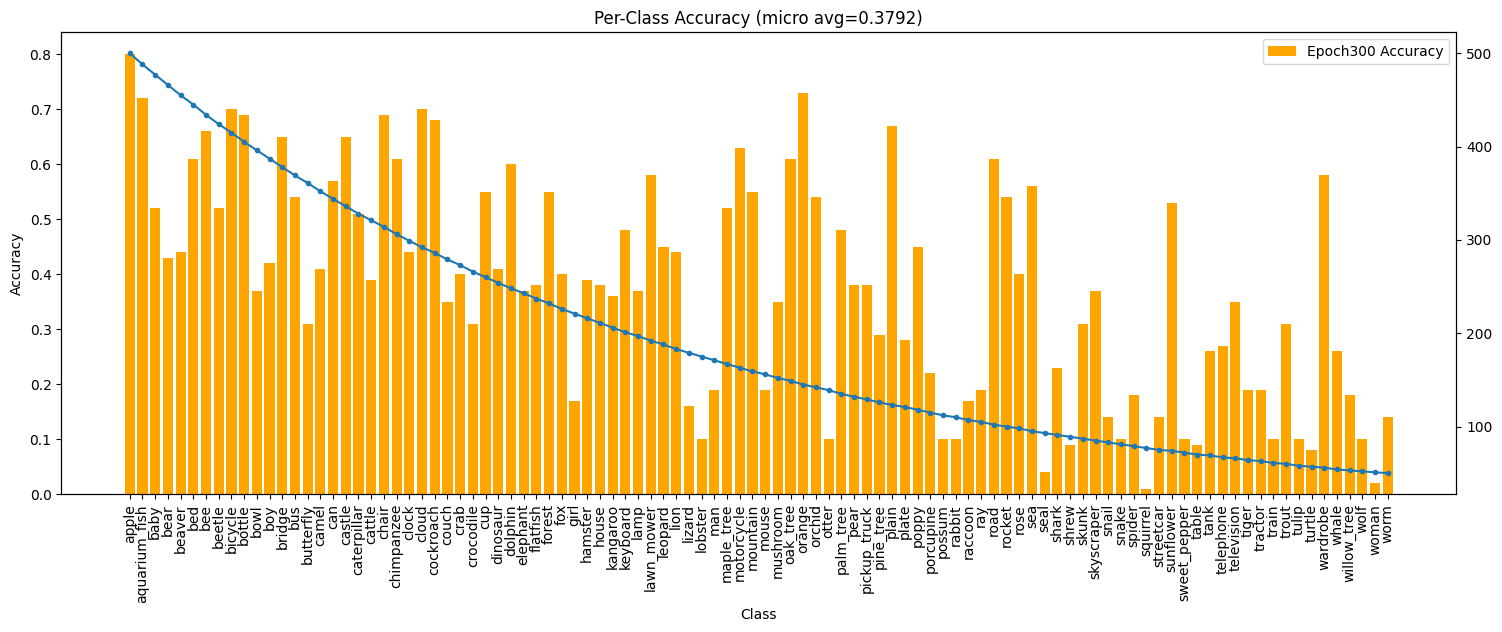

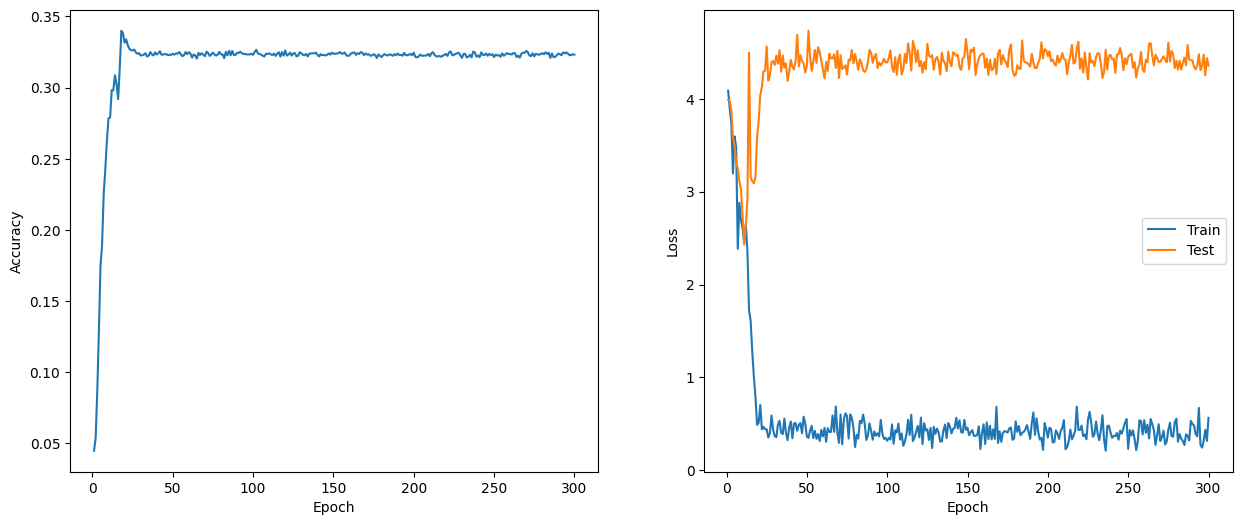

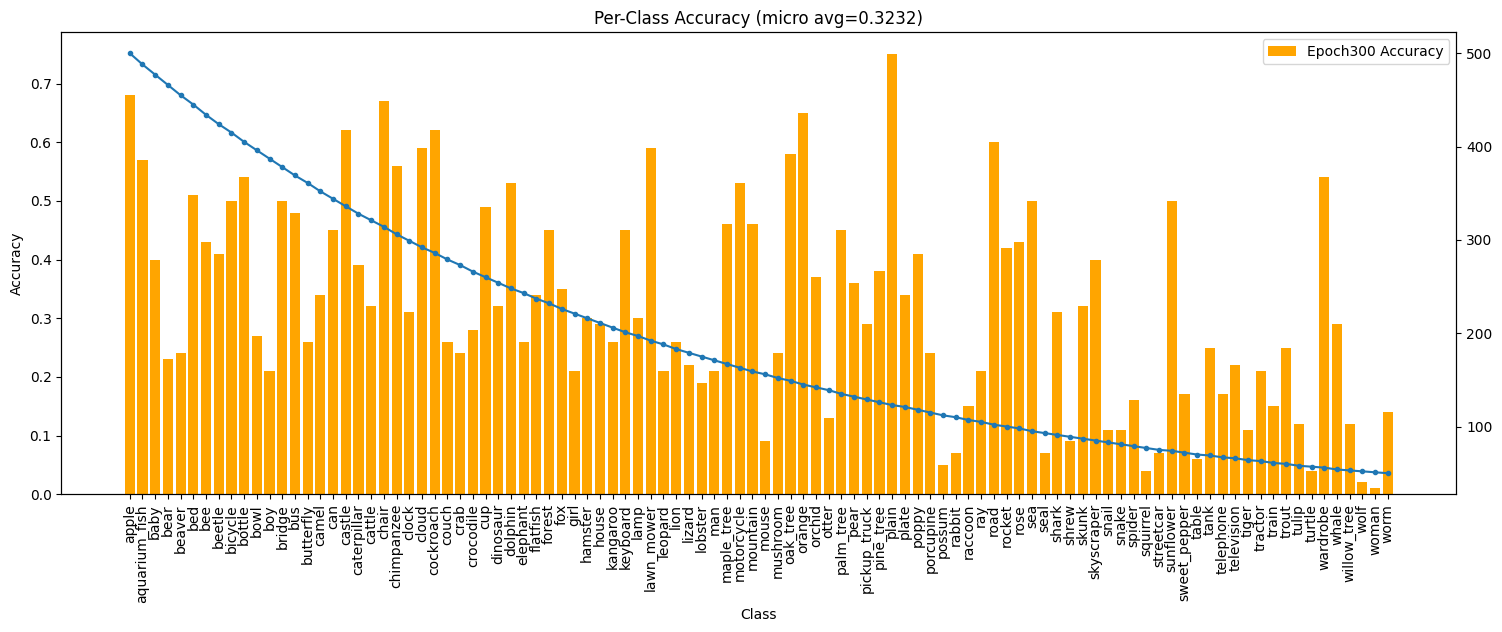

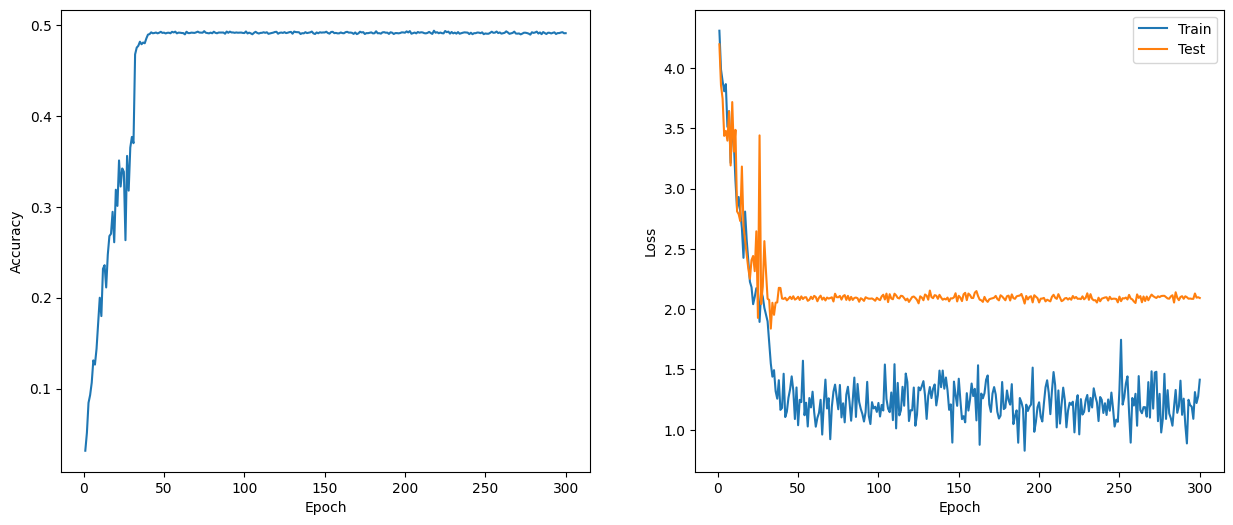

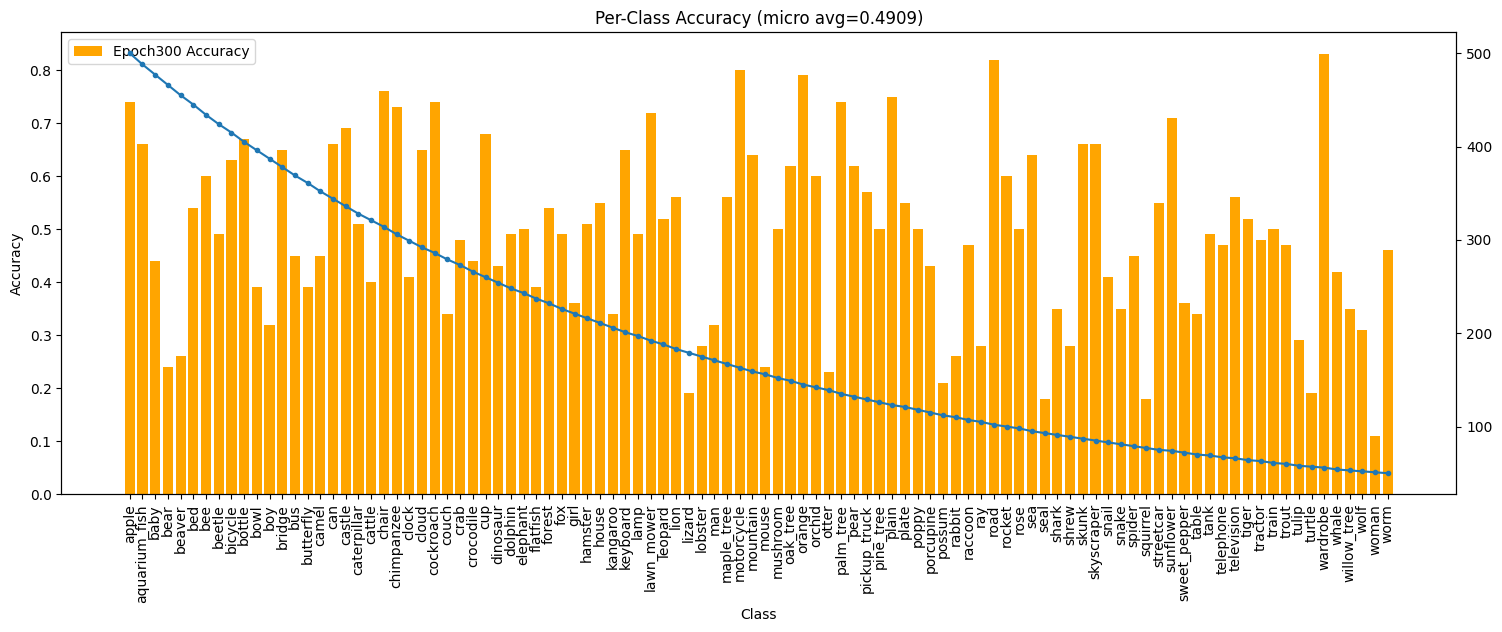

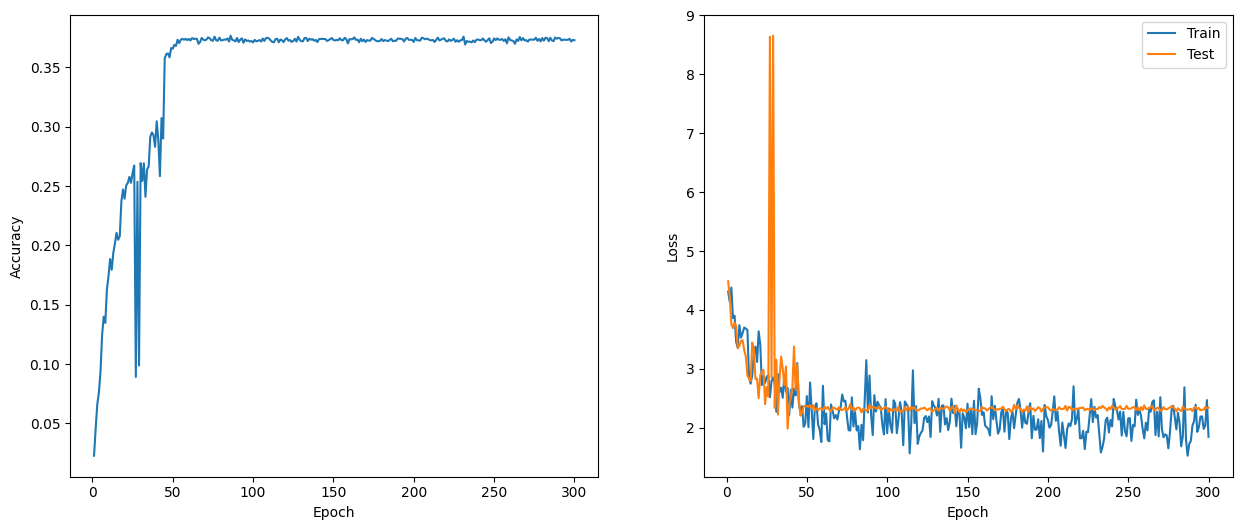

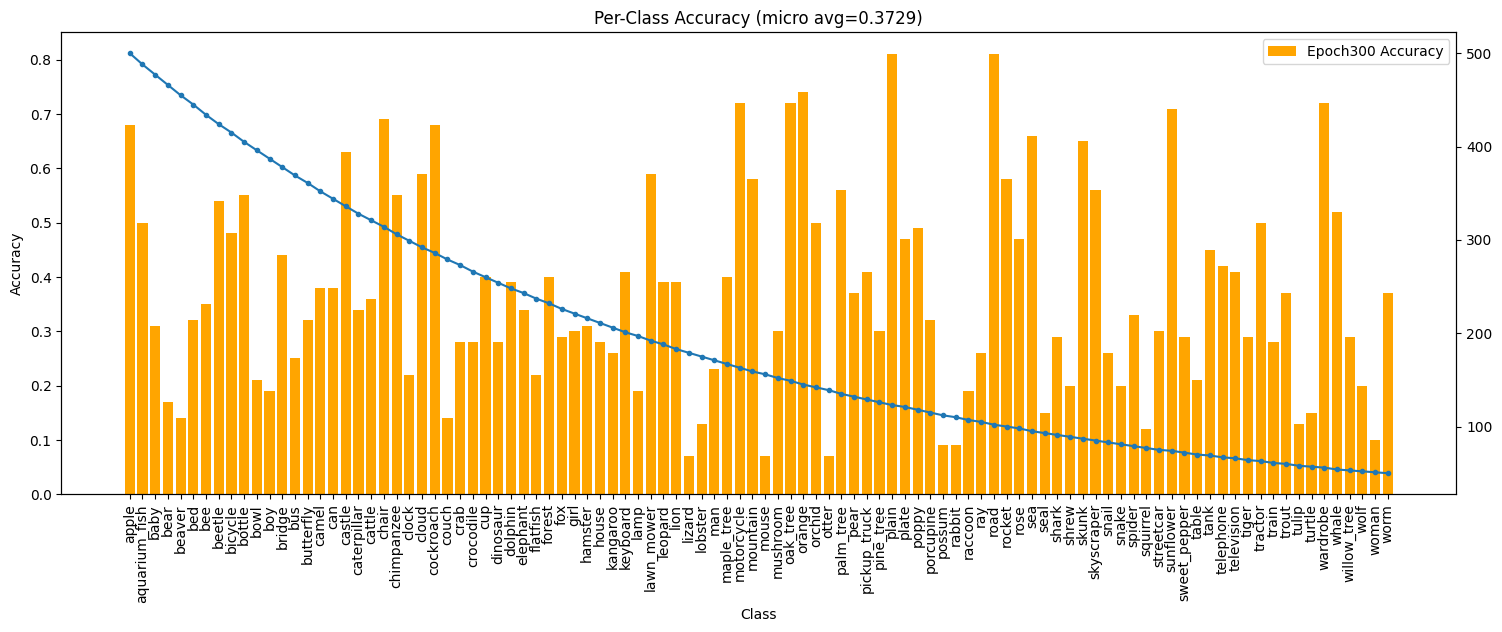

--------------------


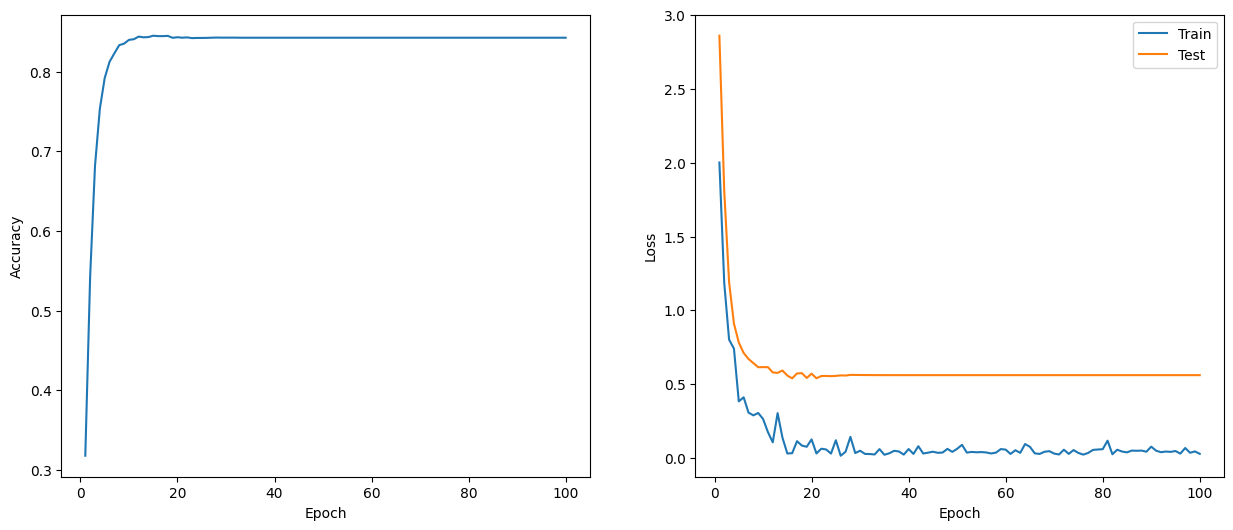

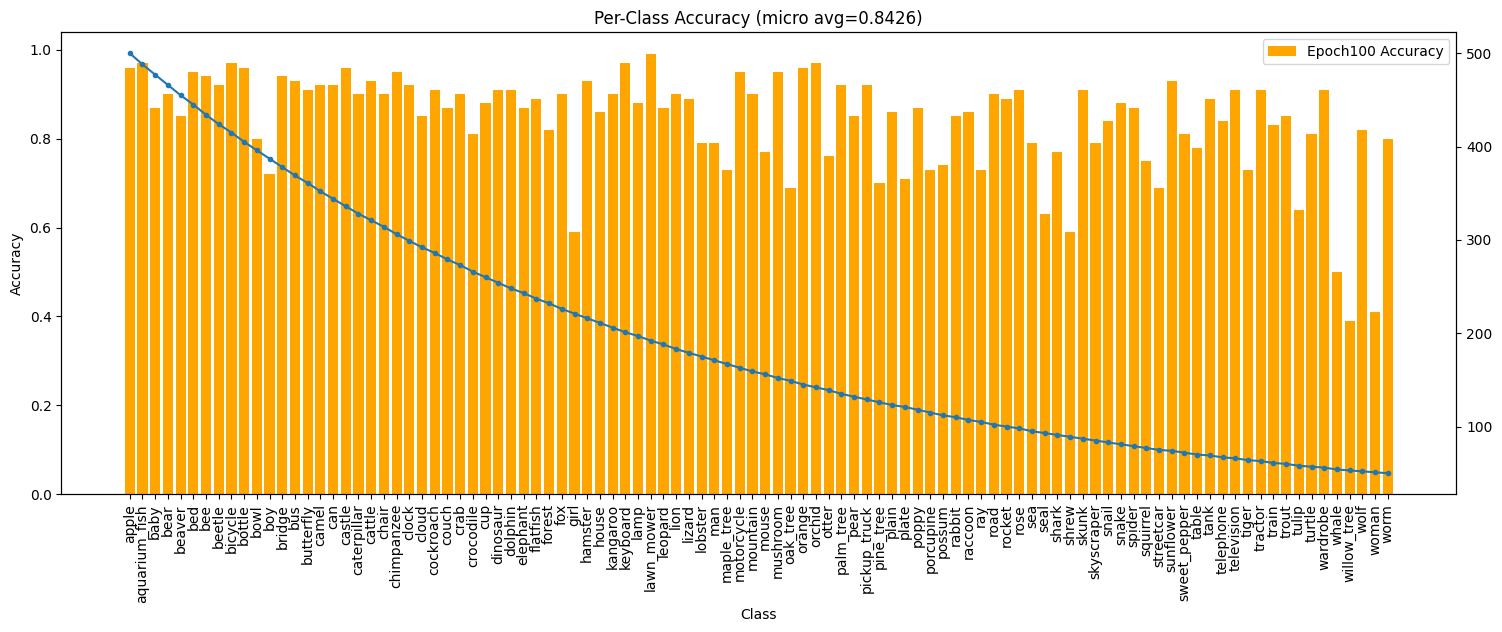

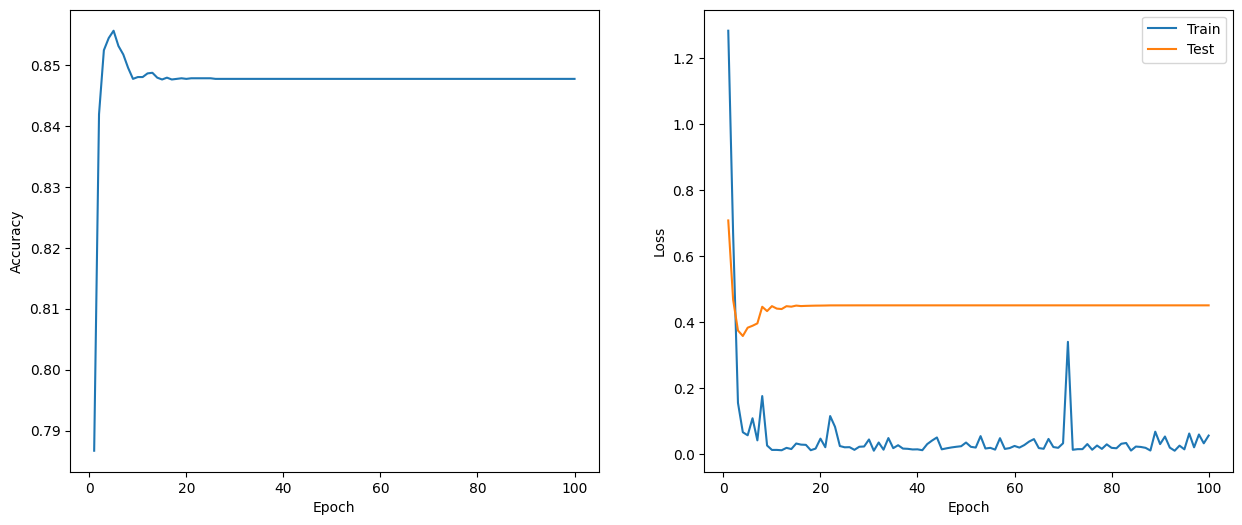

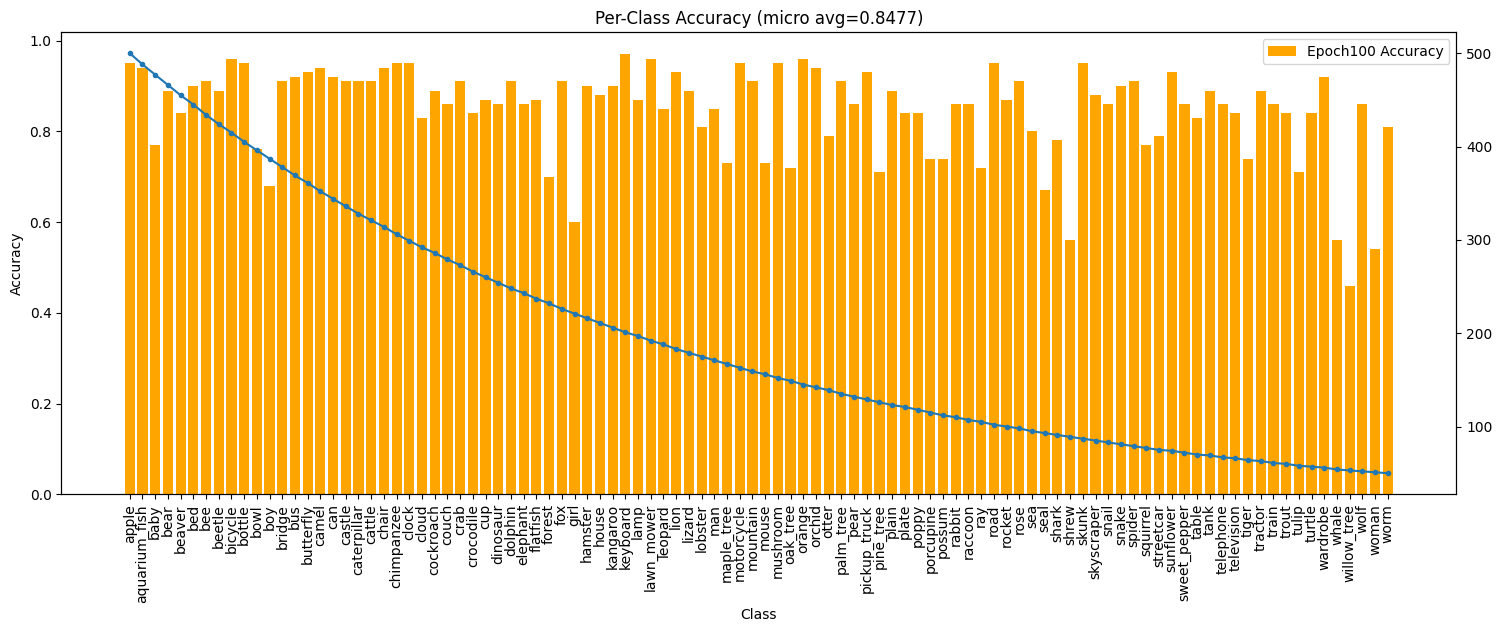

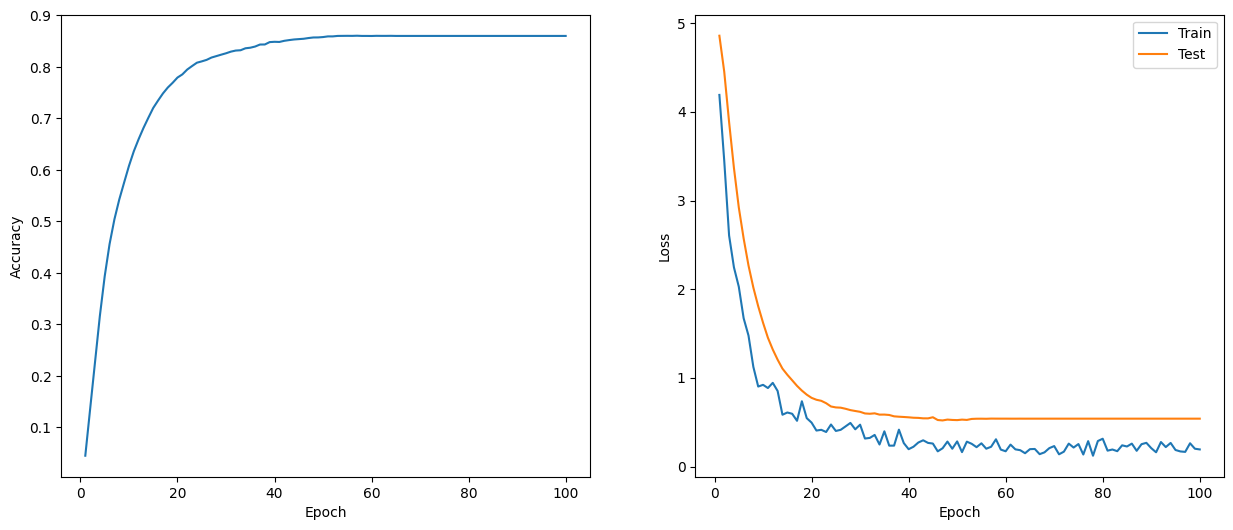

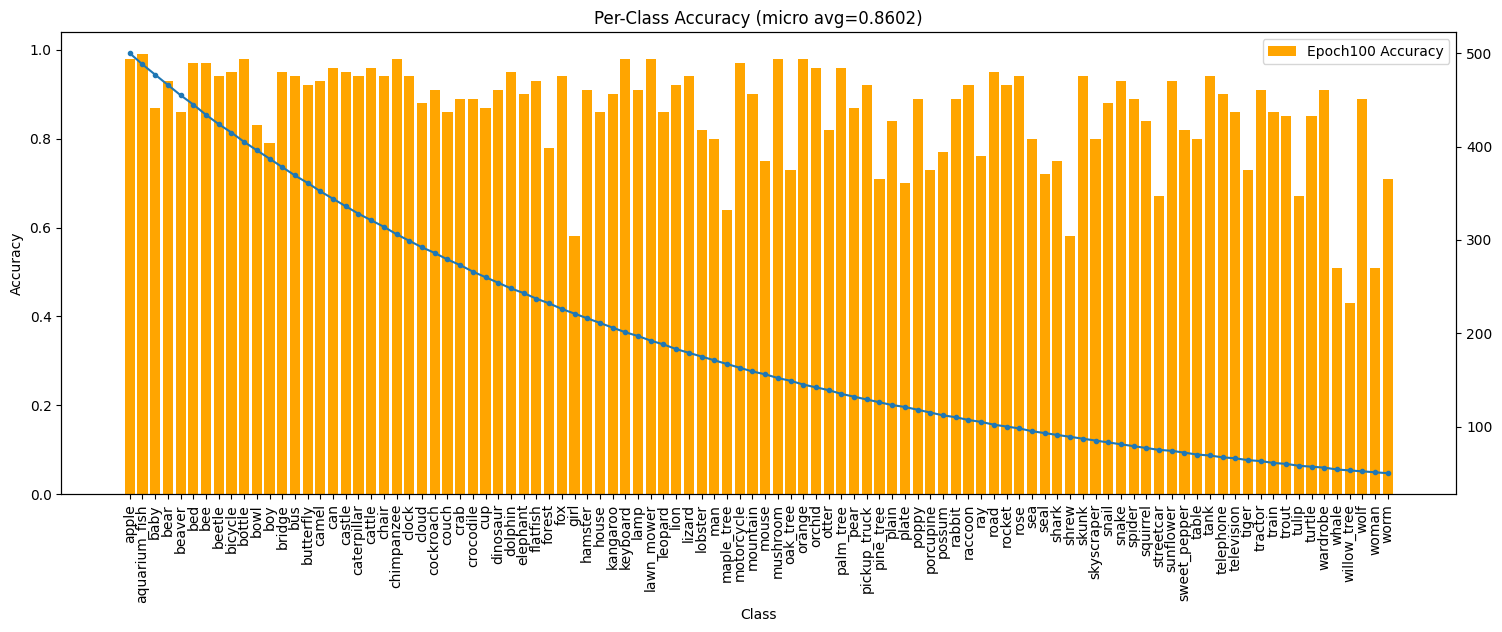

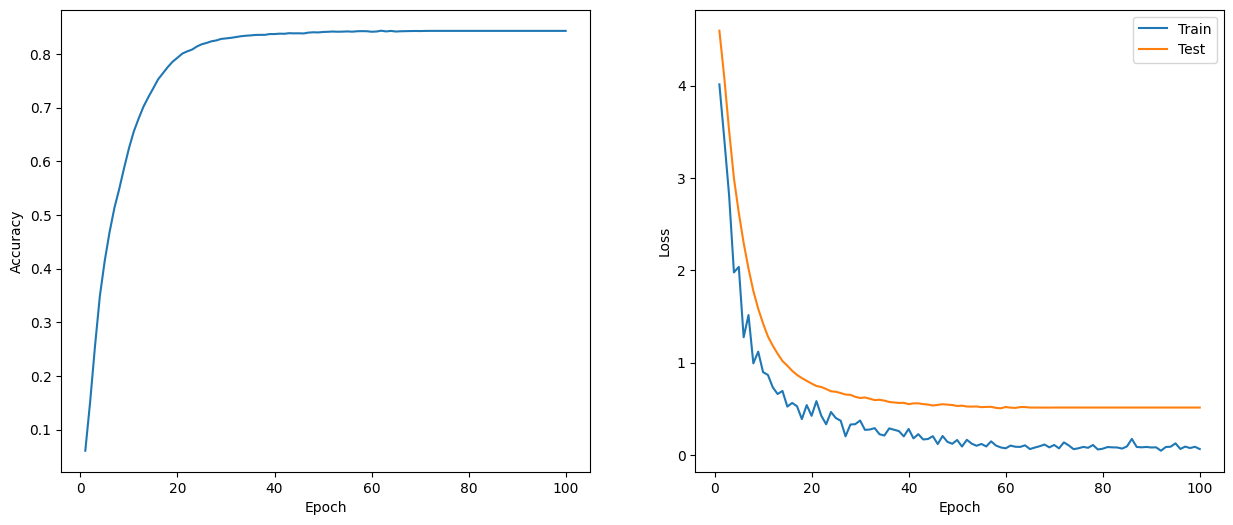

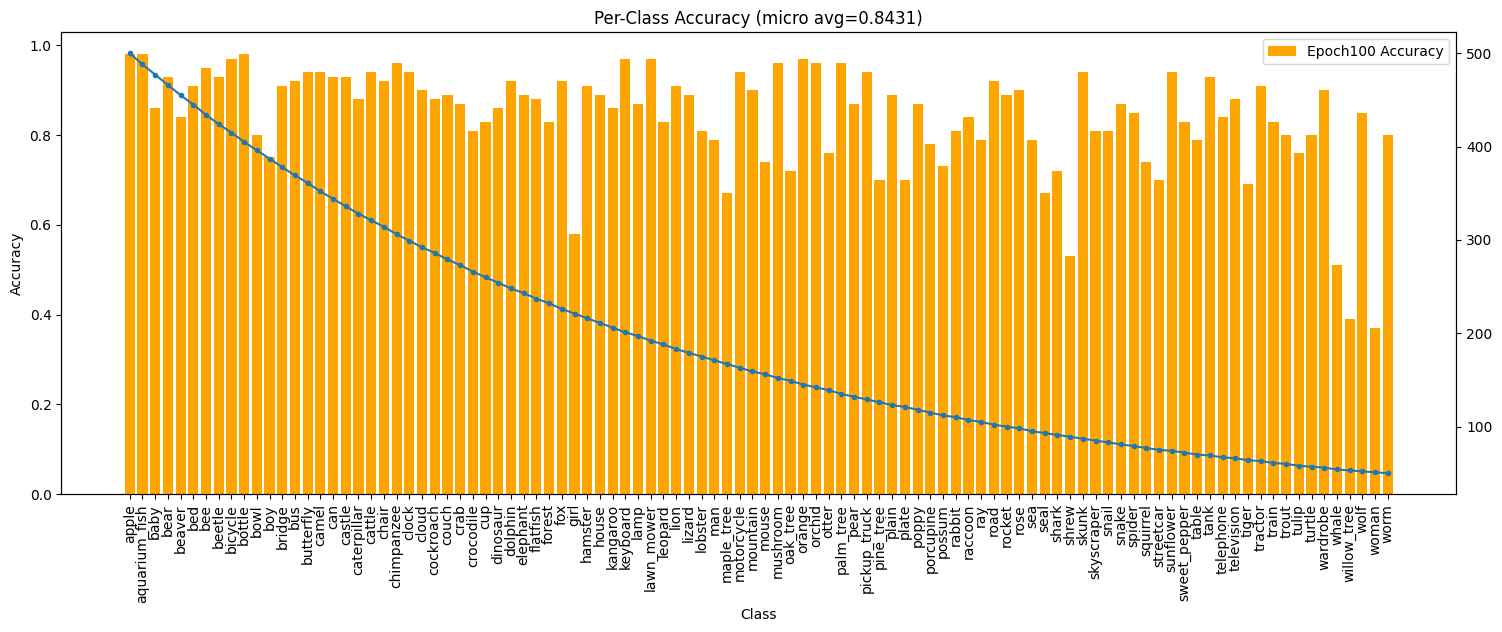

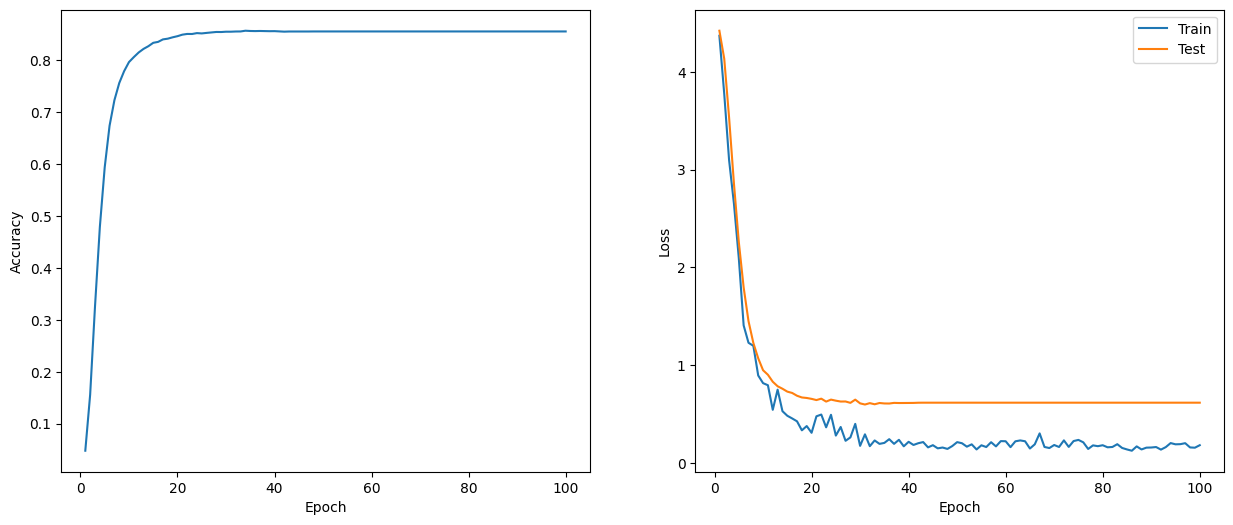

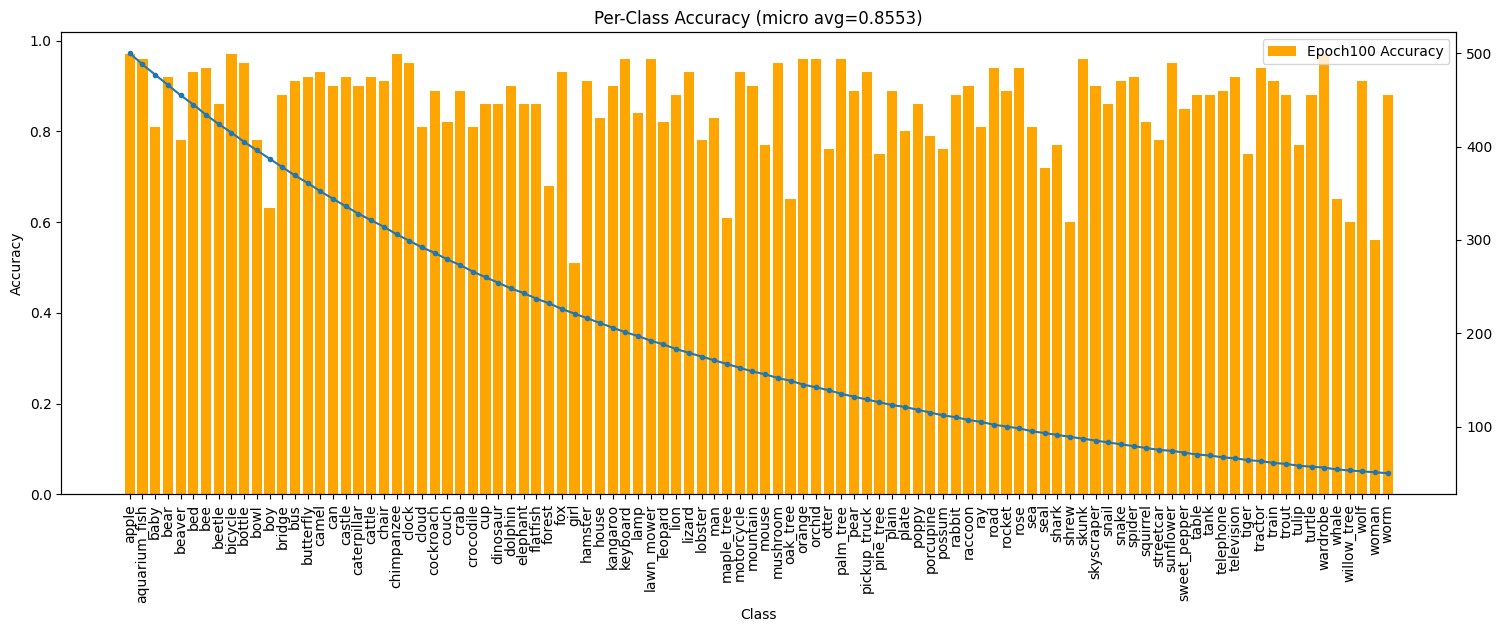

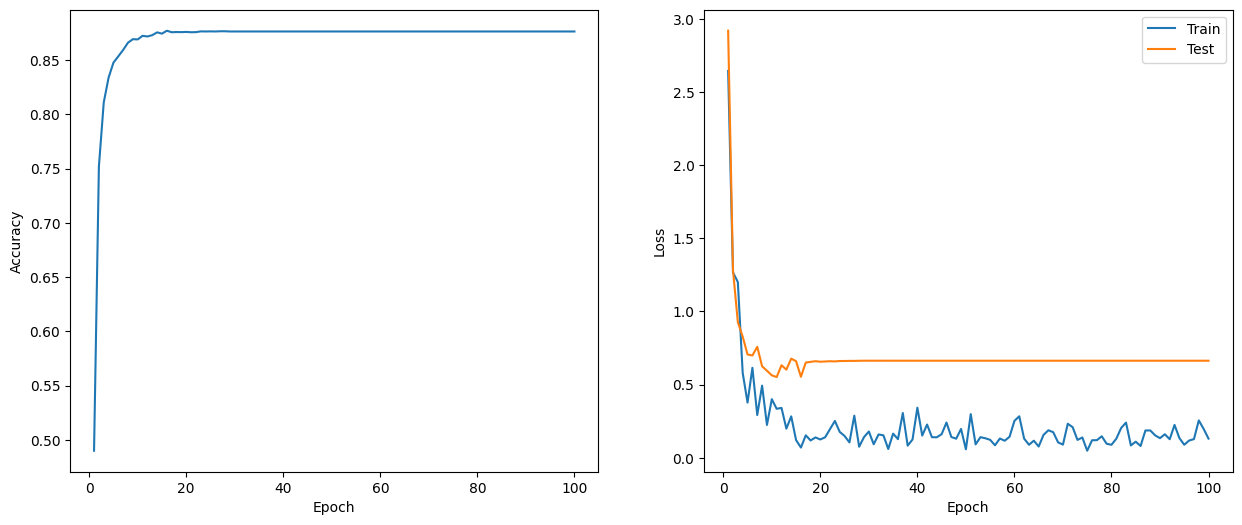

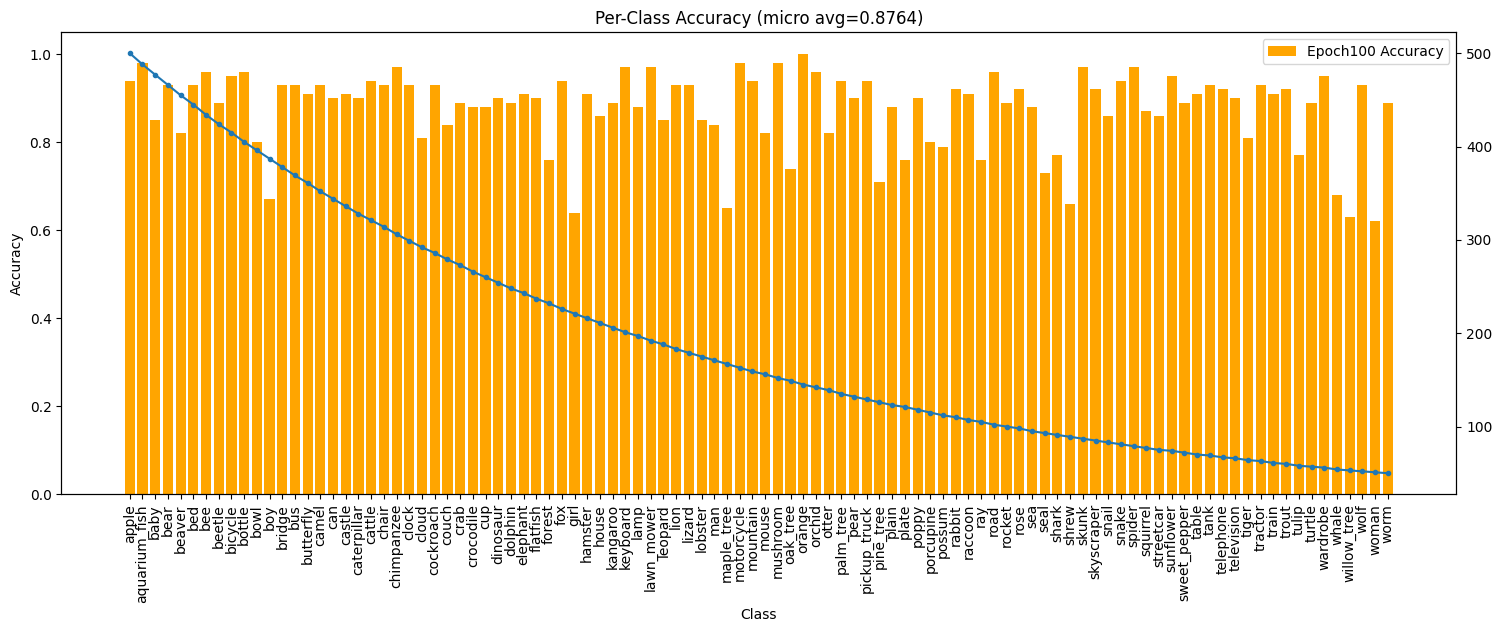

In [105]:
train_log_summary('./cifar100_models/SmallVGG_naive_300ep.csv',100,check_epoch=300,frequency_distribution=img_num_per_cls,class_names=class_names)
train_log_summary('./cifar100_models/SmallVGG_clone_300ep.csv',100,check_epoch=300,frequency_distribution=img_num_per_cls,class_names=class_names)
train_log_summary('./cifar100_models/SmallVGG_aug_300ep.csv',100,check_epoch=300,frequency_distribution=img_num_per_cls,class_names=class_names)
train_log_summary('./cifar100_models/SmallVGG_wd_300ep.csv',100,check_epoch=300,frequency_distribution=img_num_per_cls,class_names=class_names)
train_log_summary('./cifar100_models/SmallVGG_pcw_300ep.csv',100,check_epoch=300,frequency_distribution=img_num_per_cls,class_names=class_names)
train_log_summary('./cifar100_models/SmallVGG_aug_wd_pcw_300ep.csv',100,check_epoch=300,frequency_distribution=img_num_per_cls,class_names=class_names)
print("--------------------")
train_log_summary('./cifar100_models/ResNet32_naive_300ep.csv',100,check_epoch=300,frequency_distribution=img_num_per_cls,class_names=class_names)
train_log_summary('./cifar100_models/ResNet32_clone_300ep.csv',100,check_epoch=300,frequency_distribution=img_num_per_cls,class_names=class_names)
train_log_summary('./cifar100_models/ResNet32_aug_300ep.csv',100,check_epoch=300,frequency_distribution=img_num_per_cls,class_names=class_names)
train_log_summary('./cifar100_models/ResNet32_wd_300ep.csv',100,check_epoch=300,frequency_distribution=img_num_per_cls,class_names=class_names)
train_log_summary('./cifar100_models/ResNet32_pcw_300ep.csv',100,check_epoch=300,frequency_distribution=img_num_per_cls,class_names=class_names)
train_log_summary('./cifar100_models/ResNet32_aug_wd_pcw_300ep.csv',100,check_epoch=300,frequency_distribution=img_num_per_cls,class_names=class_names)
train_log_summary('./cifar100_models/ResNet32_aug_wd_pcw_rf_300ep.csv',100,check_epoch=300,frequency_distribution=img_num_per_cls,class_names=class_names)
print("--------------------")
train_log_summary('./cifar100_models/SmallViT_naive_100ep.csv',100,check_epoch=100,frequency_distribution=img_num_per_cls,class_names=class_names)
train_log_summary('./cifar100_models/SmallViT_clone_100ep.csv',100,check_epoch=100,frequency_distribution=img_num_per_cls,class_names=class_names)
train_log_summary('./cifar100_models/SmallViT_aug_100ep.csv',100,check_epoch=100,frequency_distribution=img_num_per_cls,class_names=class_names)
train_log_summary('./cifar100_models/SmallViT_wd_100ep.csv',100,check_epoch=100,frequency_distribution=img_num_per_cls,class_names=class_names)
train_log_summary('./cifar100_models/SmallViT_pcw_100ep.csv',100,check_epoch=100,frequency_distribution=img_num_per_cls,class_names=class_names)
train_log_summary('./cifar100_models/SmallViT_aug_wd_pcw_100ep.csv',100,check_epoch=100,frequency_distribution=img_num_per_cls,class_names=class_names)


## F1 Scores

In [104]:
# 定义计算每个类别的 F1 Score 并绘制柱状图的函数
def calculate_f1_score_and_plot_torchmetrics(model, testloader, class_names=None):
    # 切换到评估模式
    model.eval()

    all_preds = []
    all_labels = []

    # 使用模型进行预测
    with torch.no_grad():
        for x, y in testloader:
            # 将数据传输到设备（如 GPU）上，如果可用
            x, y = x.to(device), y.to(device)

            # 得到预测结果
            y_pred = model(x)
            _, predicted = torch.max(y_pred, 1)

            # 累积预测结果和真实标签
            all_preds.append(predicted)
            all_labels.append(y)

    # 将累积的结果拼接为单个 Tensor
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # 使用 TorchMetrics 计算每个类别的 F1 Score
    num_classes = len(torch.unique(all_labels))
    f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='none').to(device)  # 计算每个类别的 F1 Score
    f1_score_per_class = f1(all_preds, all_labels)
    
    # 使用 TorchMetrics 计算 Macro 平均的 F1 Score
    # macro_f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='macro').to(device)
    # macro_f1_score = macro_f1(all_preds, all_labels)
    macro_f1_score = f1_score_per_class.sum() / num_classes

    # 打印每个类别的 F1 Score
    # for class_id in range(len(f1_score_per_class)):
    #     print(f"F1 Score for Class {class_id}: {f1_score_per_class[class_id].item():.4f}")

    # 绘制 F1 Score 的柱状图
    plt.figure(figsize=(18, 6))
    bars = plt.bar(class_names or range(num_classes), f1_score_per_class.cpu().numpy(), color='skyblue')

    f1_scores = f1_score_per_class.cpu().numpy()

    # 在柱状图的上方显示 F1 Score 数值
    for bar, score in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', ha='center', va='bottom')

    plt.xlabel('Class ID')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score for Each Class (macro avg={macro_f1_score.item():.4f})')
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--')
    plt.show()


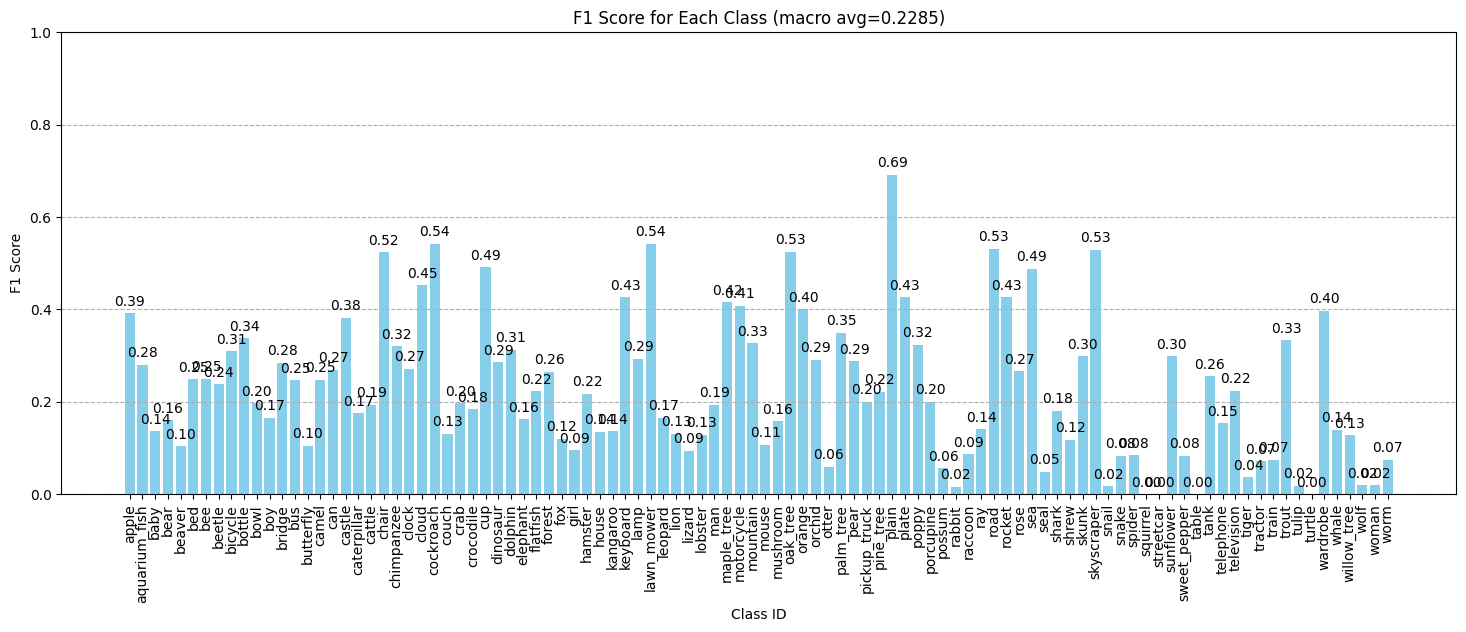

In [106]:
load_cifar100(32,False,False)
model=SmallVGG().to(device)
model.load_state_dict(torch.load("./cifar100_models/SmallVGG_naive_300ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

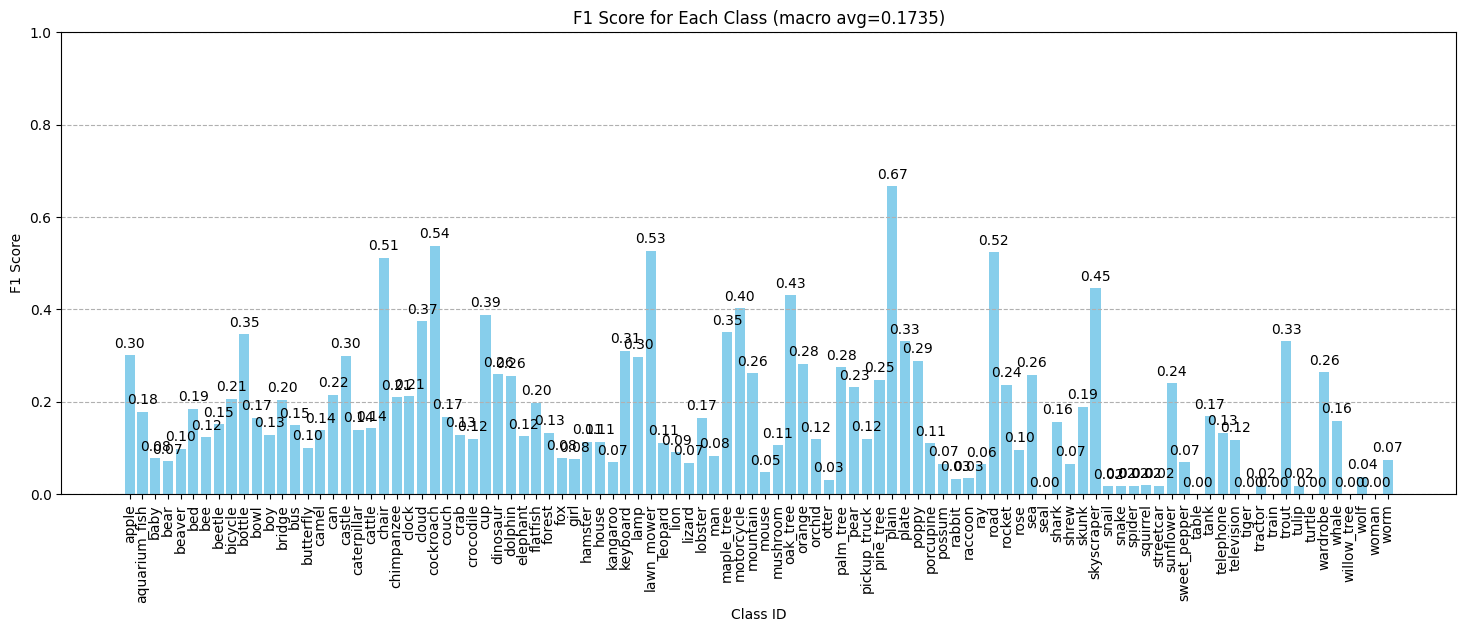

In [107]:
model=SmallVGG().to(device)
model.load_state_dict(torch.load("./cifar100_models/SmallVGG_clone_300ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

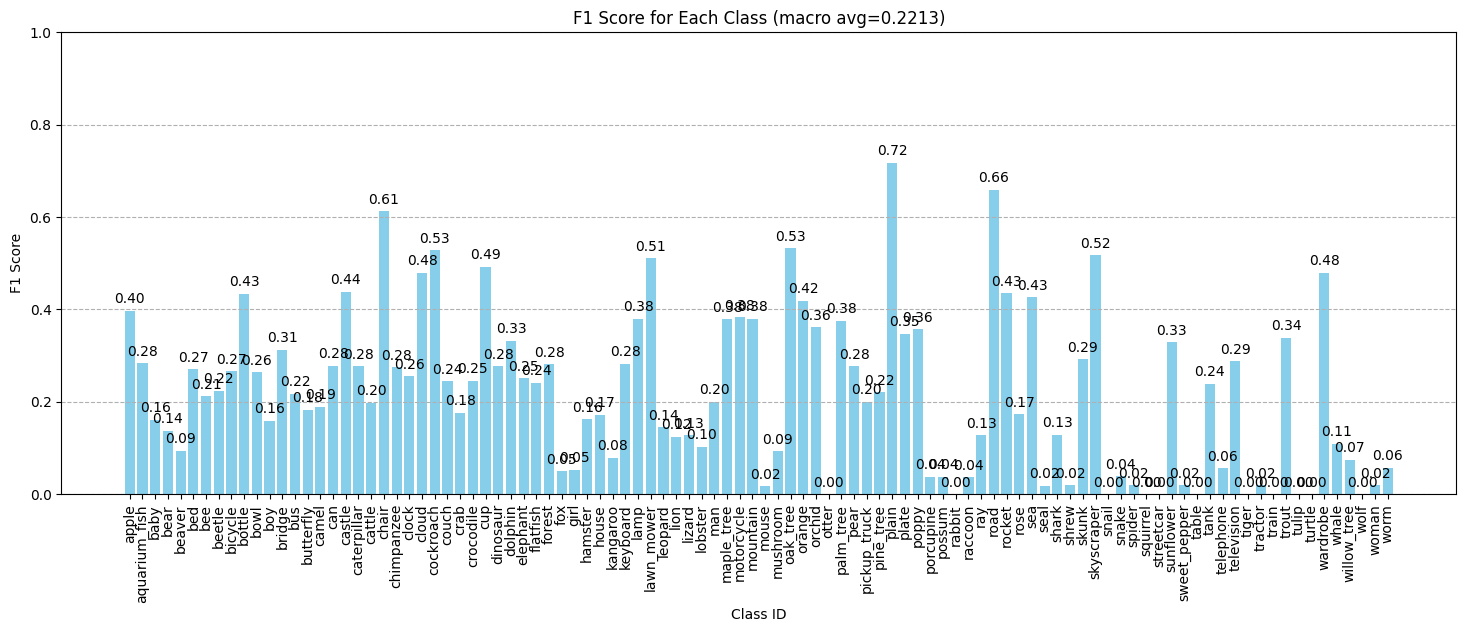

In [108]:
model=SmallVGG().to(device)
model.load_state_dict(torch.load("./cifar100_models/SmallVGG_aug_300ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

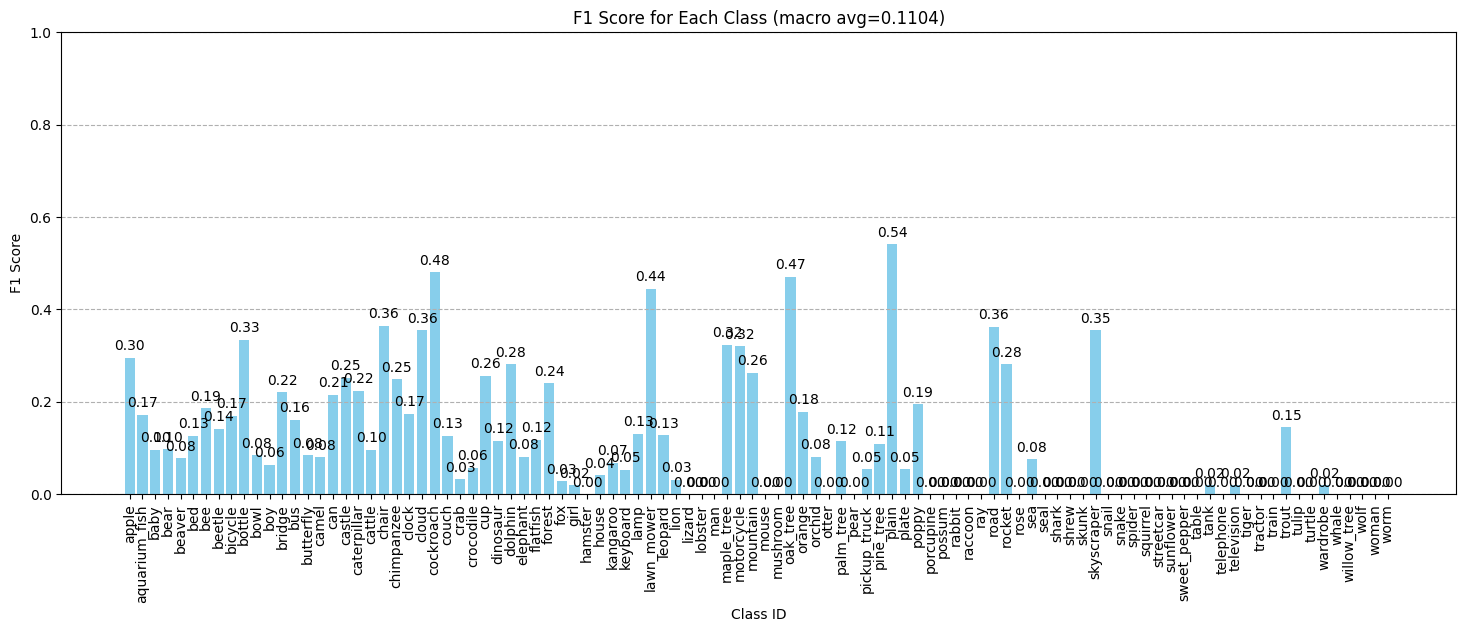

In [109]:
model=SmallVGG().to(device)
model.load_state_dict(torch.load("./cifar100_models/SmallVGG_wd_300ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

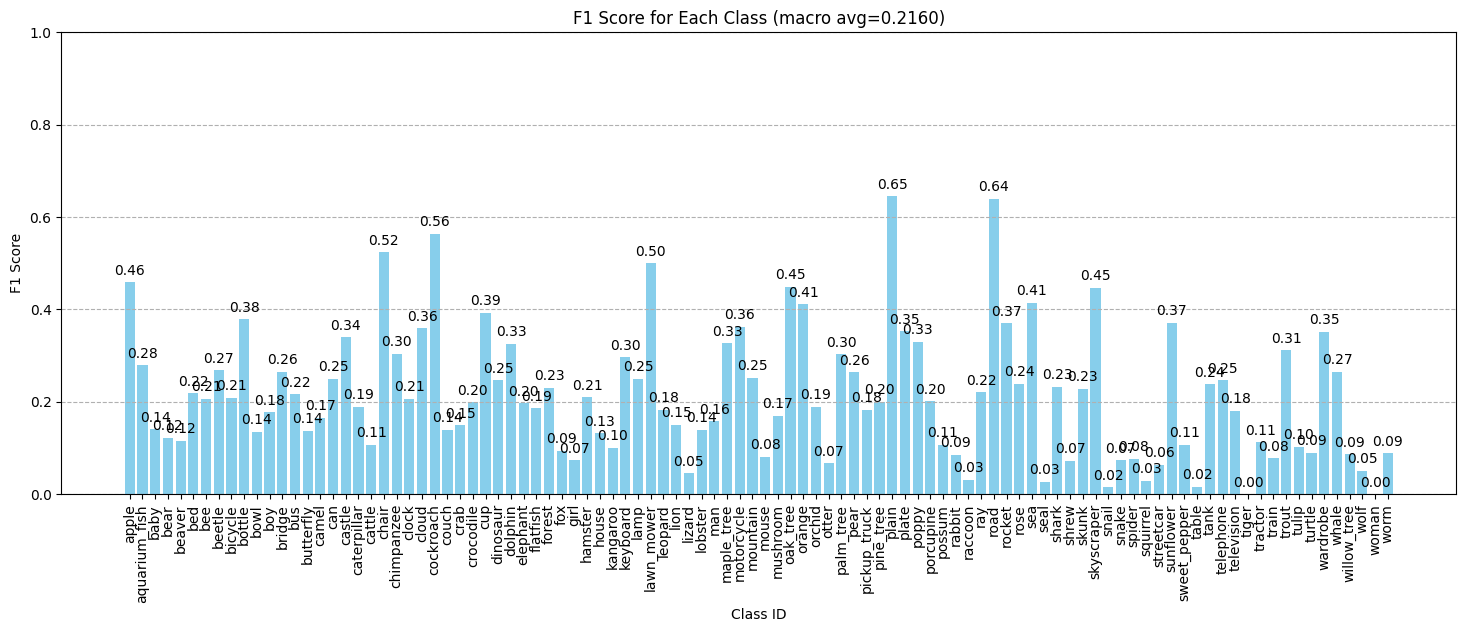

In [110]:
model=SmallVGG().to(device)
model.load_state_dict(torch.load("./cifar100_models/SmallVGG_pcw_300ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

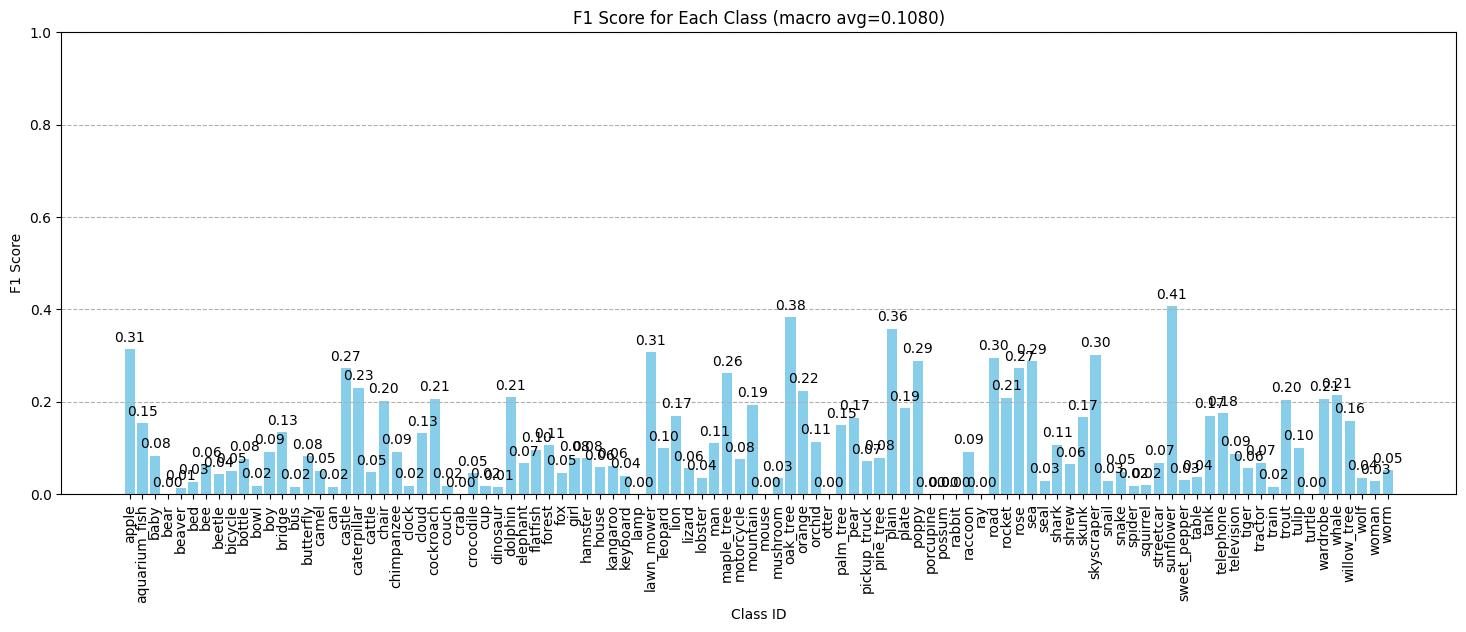

In [111]:
model=SmallVGG().to(device)
model.load_state_dict(torch.load("./cifar100_models/SmallVGG_aug_wd_pcw_300ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

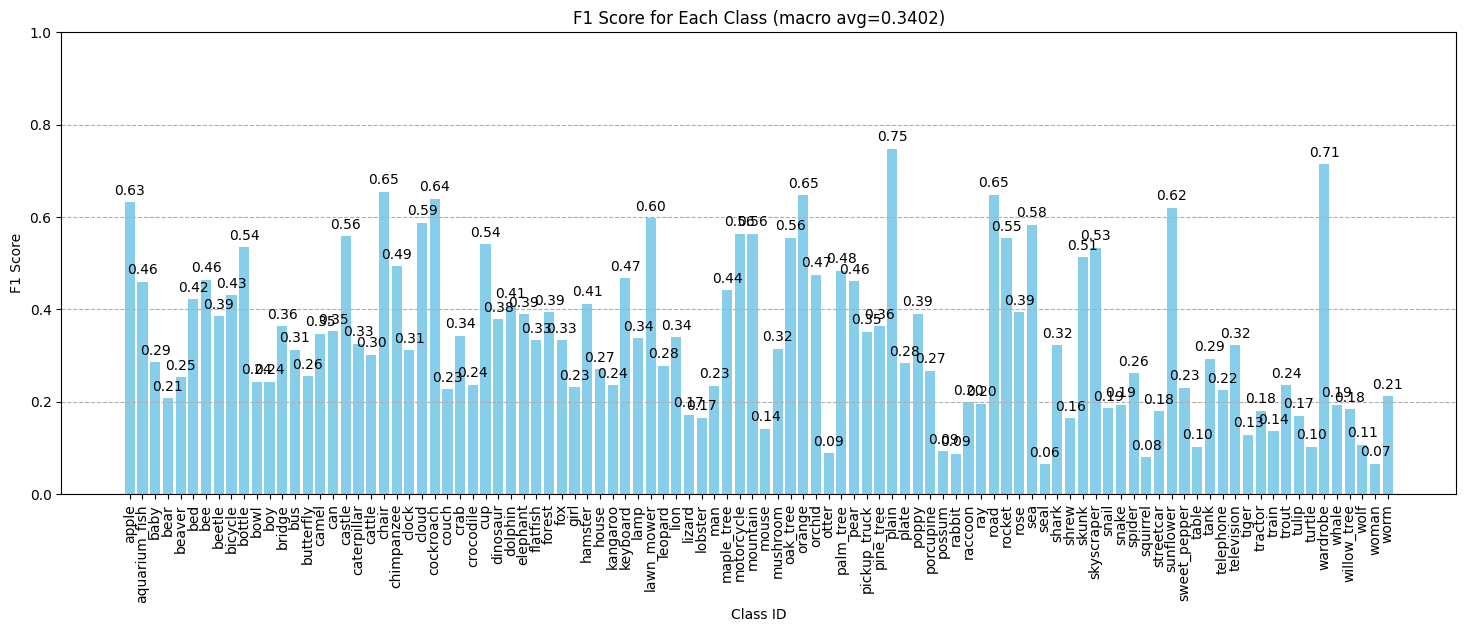

In [112]:
model=ResNet32().to(device)
model.load_state_dict(torch.load("./cifar100_models/ResNet32_naive_300ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

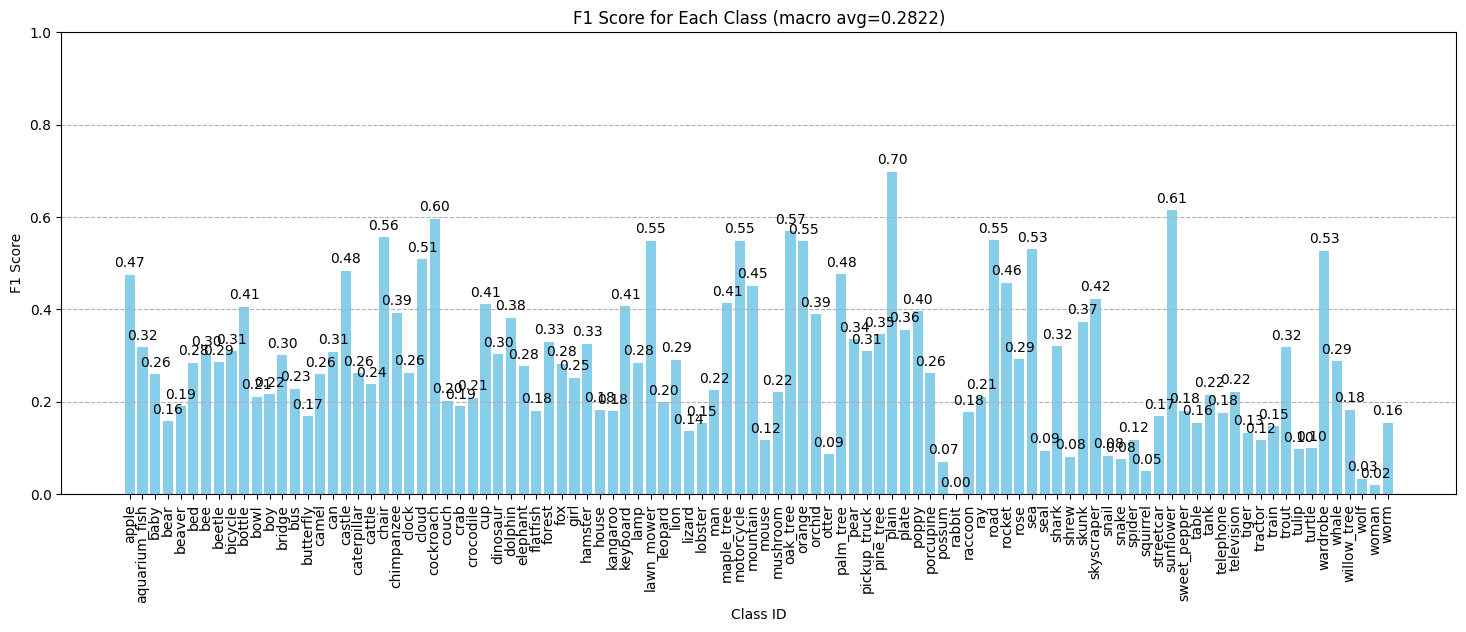

In [113]:
model=ResNet32().to(device)
model.load_state_dict(torch.load("./cifar100_models/ResNet32_clone_300ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

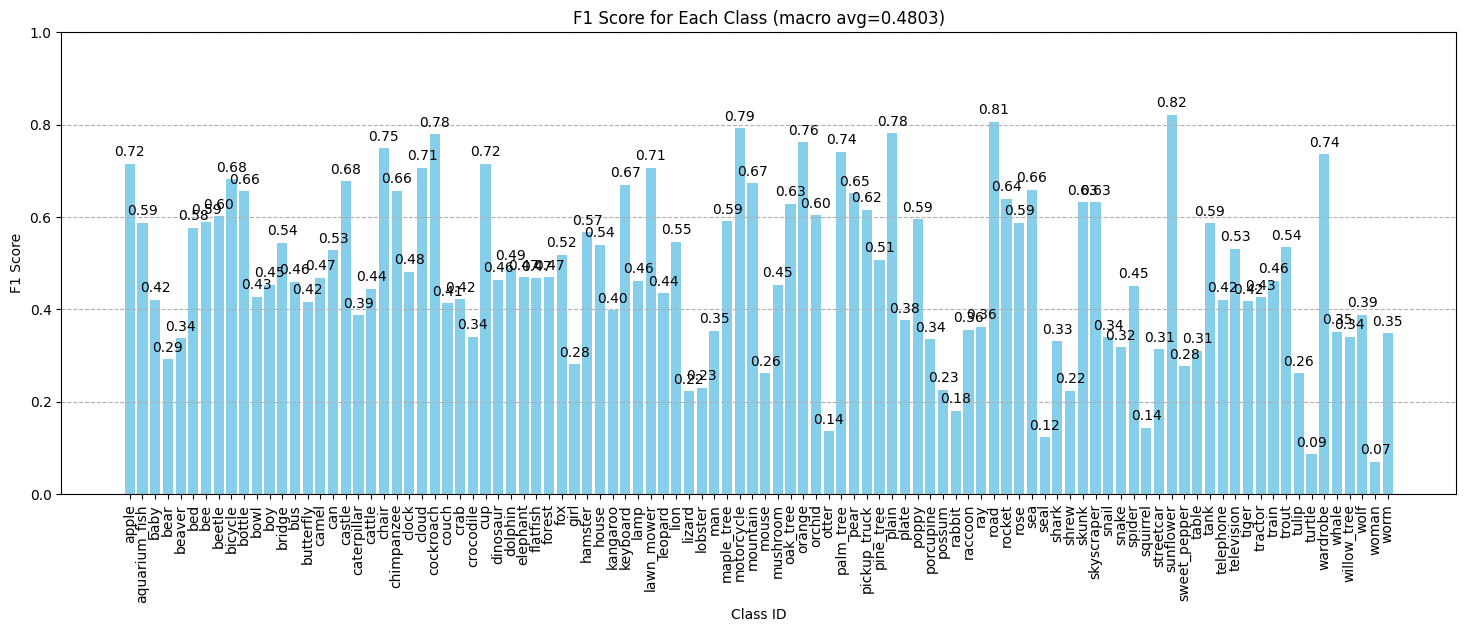

In [114]:
model=ResNet32().to(device)
model.load_state_dict(torch.load("./cifar100_models/ResNet32_aug_300ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

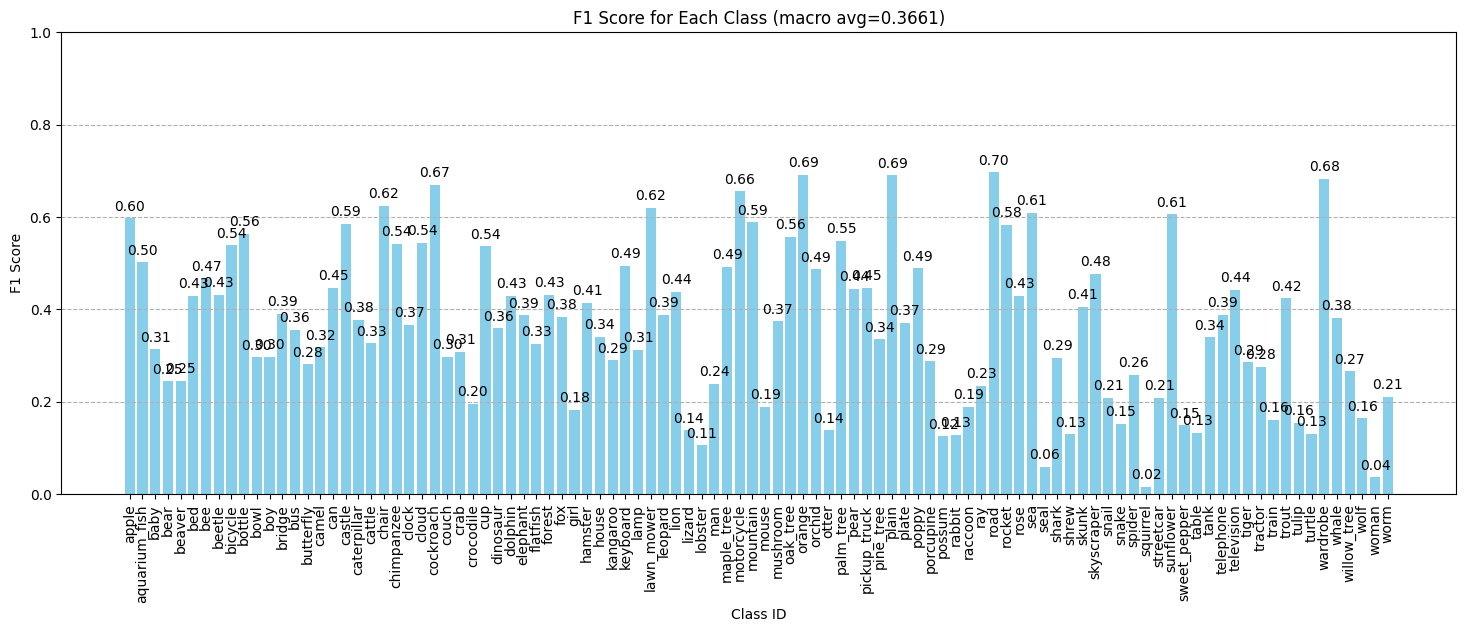

In [115]:
model=ResNet32().to(device)
model.load_state_dict(torch.load("./cifar100_models/ResNet32_wd_300ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

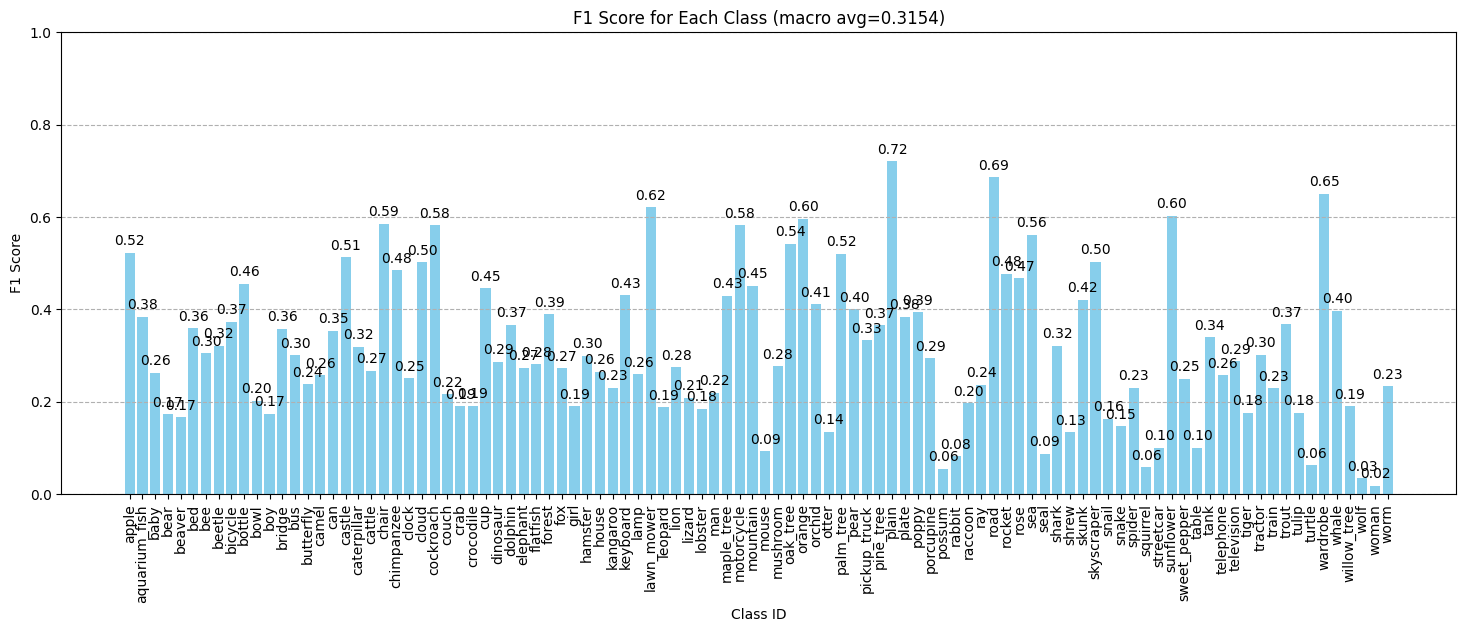

In [116]:
model=ResNet32().to(device)
model.load_state_dict(torch.load("./cifar100_models/ResNet32_pcw_300ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

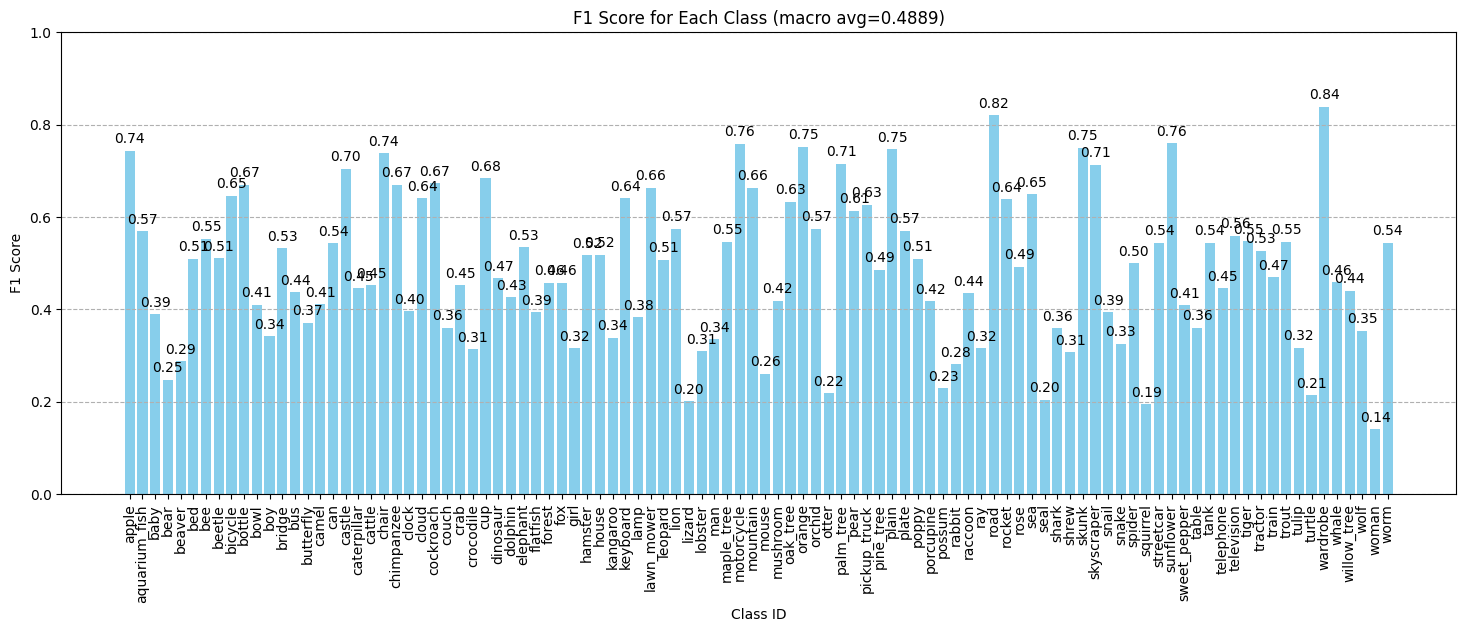

In [117]:
model=ResNet32().to(device)
model.load_state_dict(torch.load("./cifar100_models/ResNet32_aug_wd_pcw_300ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

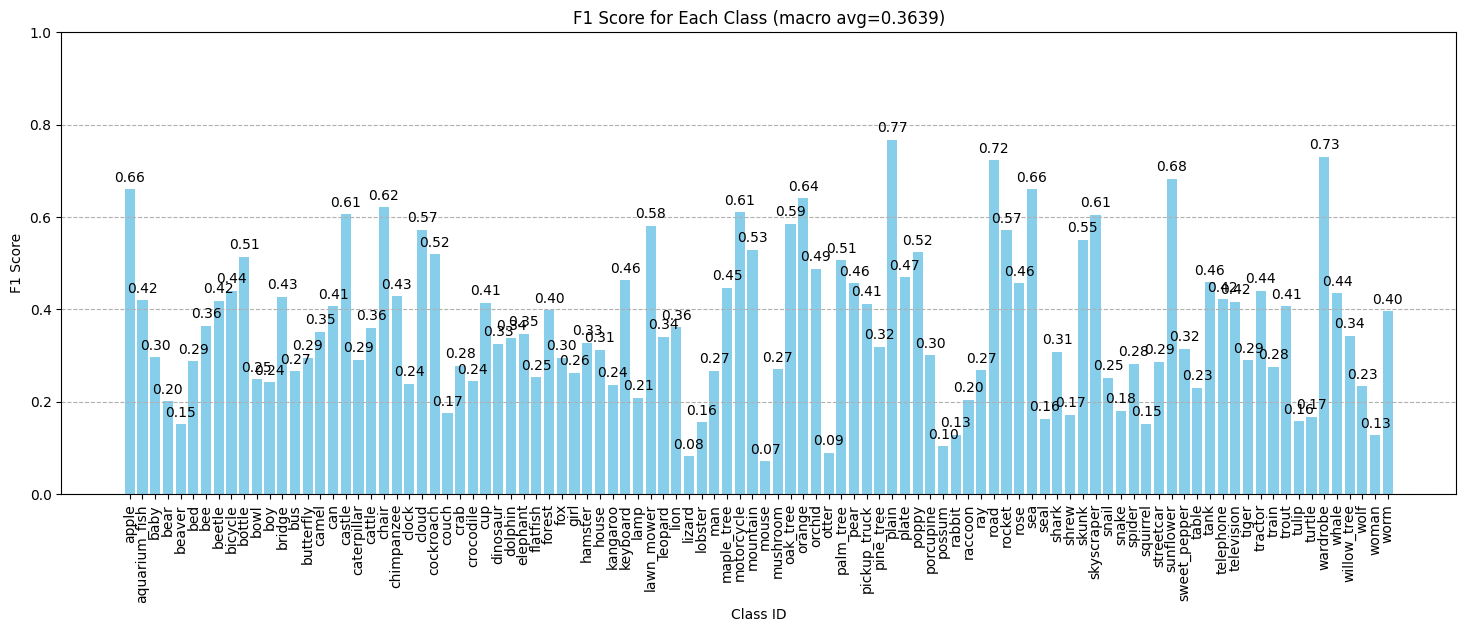

In [118]:
model=ResNet32_fusion().to(device)
model.load_state_dict(torch.load("./cifar100_models/ResNet32_aug_wd_pcw_rf_300ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

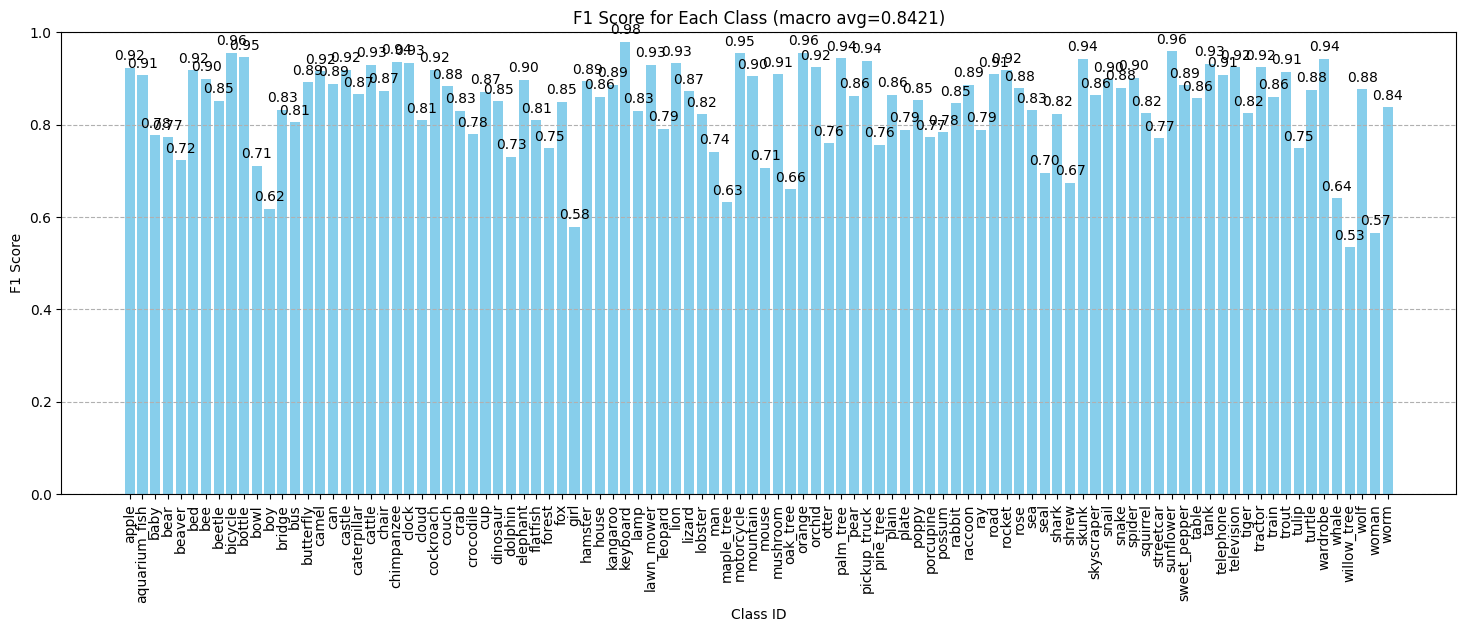

In [119]:
load_cifar100(224,False,False)
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=100)
model = model.to(device)
model.load_state_dict(torch.load("./cifar100_models/SmallViT_naive_100ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

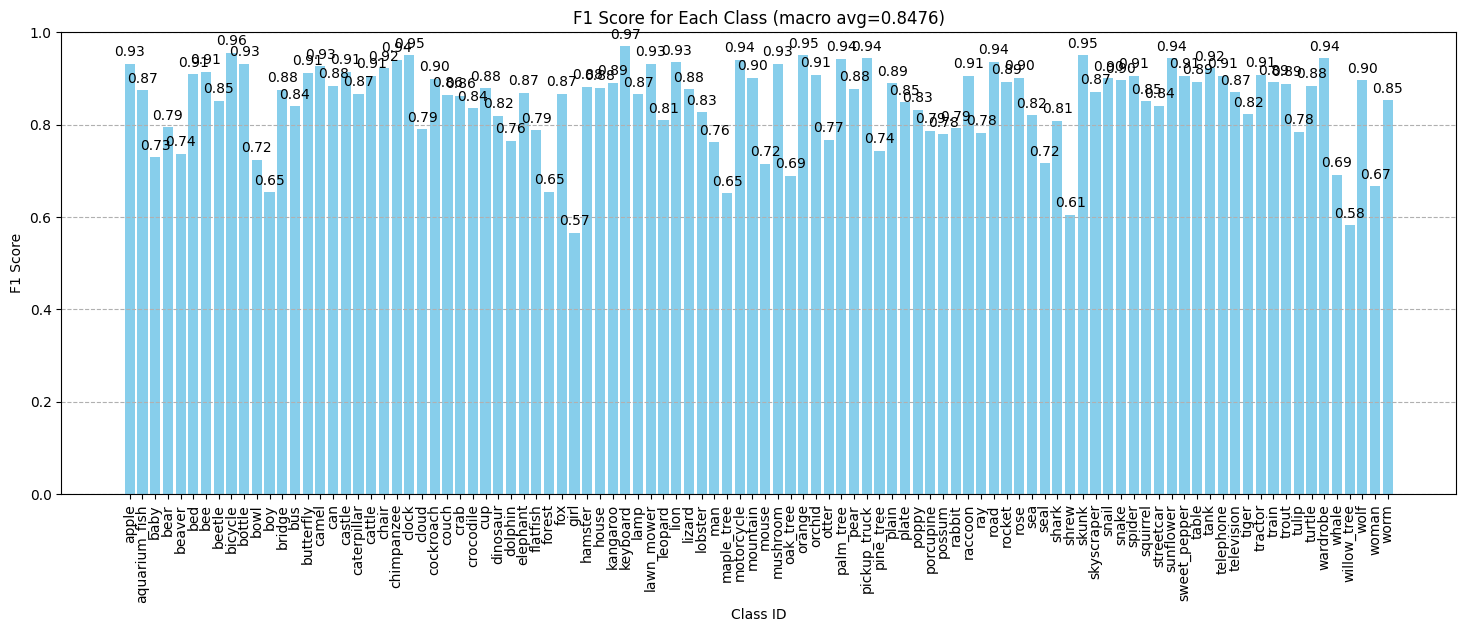

In [120]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=100)
model = model.to(device)
model.load_state_dict(torch.load("./cifar100_models/SmallViT_clone_100ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

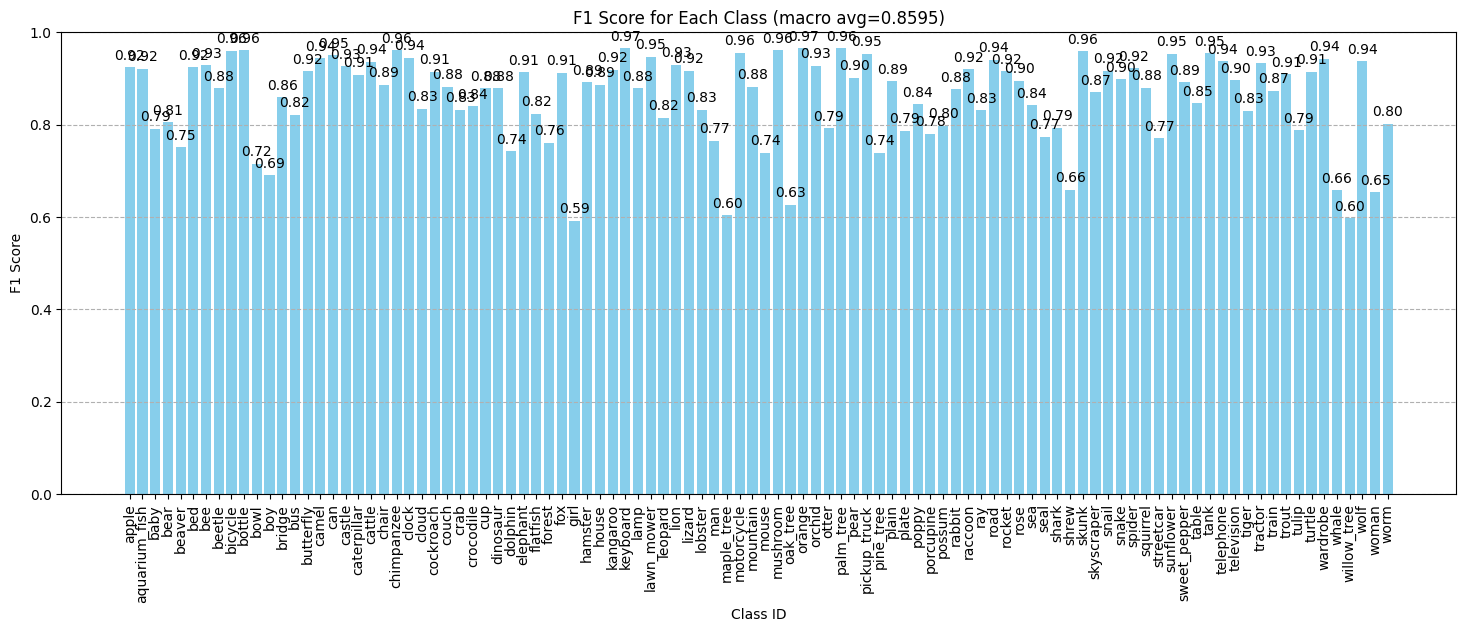

In [121]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=100)
model = model.to(device)
model.load_state_dict(torch.load("./cifar100_models/SmallViT_aug_100ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

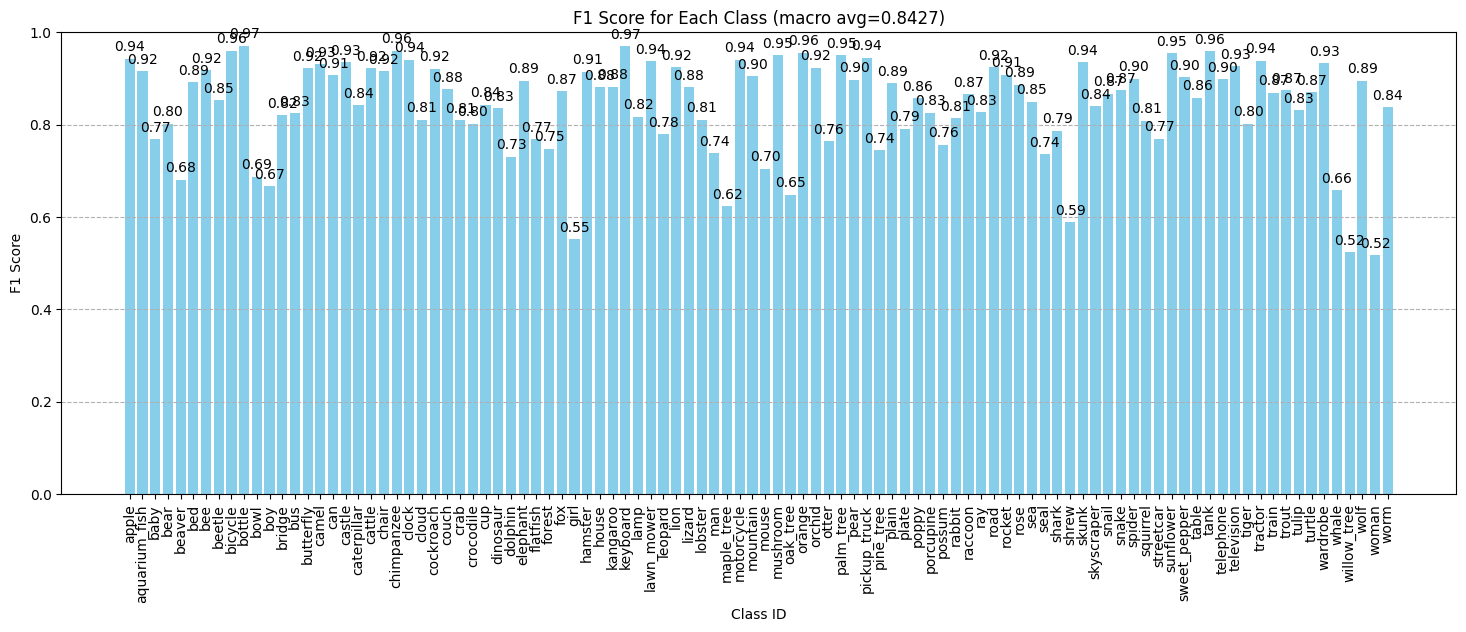

In [122]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=100)
model = model.to(device)
model.load_state_dict(torch.load("./cifar100_models/SmallViT_wd_100ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

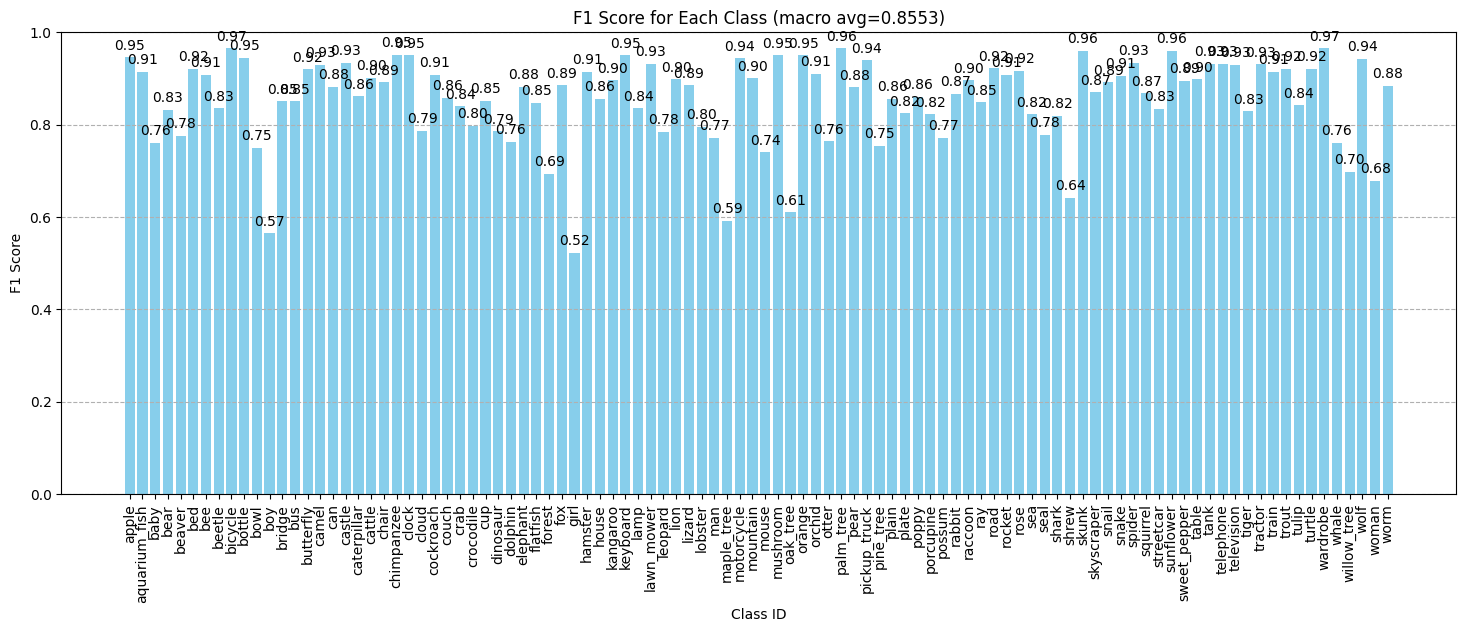

In [123]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=100)
model = model.to(device)
model.load_state_dict(torch.load("./cifar100_models/SmallViT_pcw_100ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)

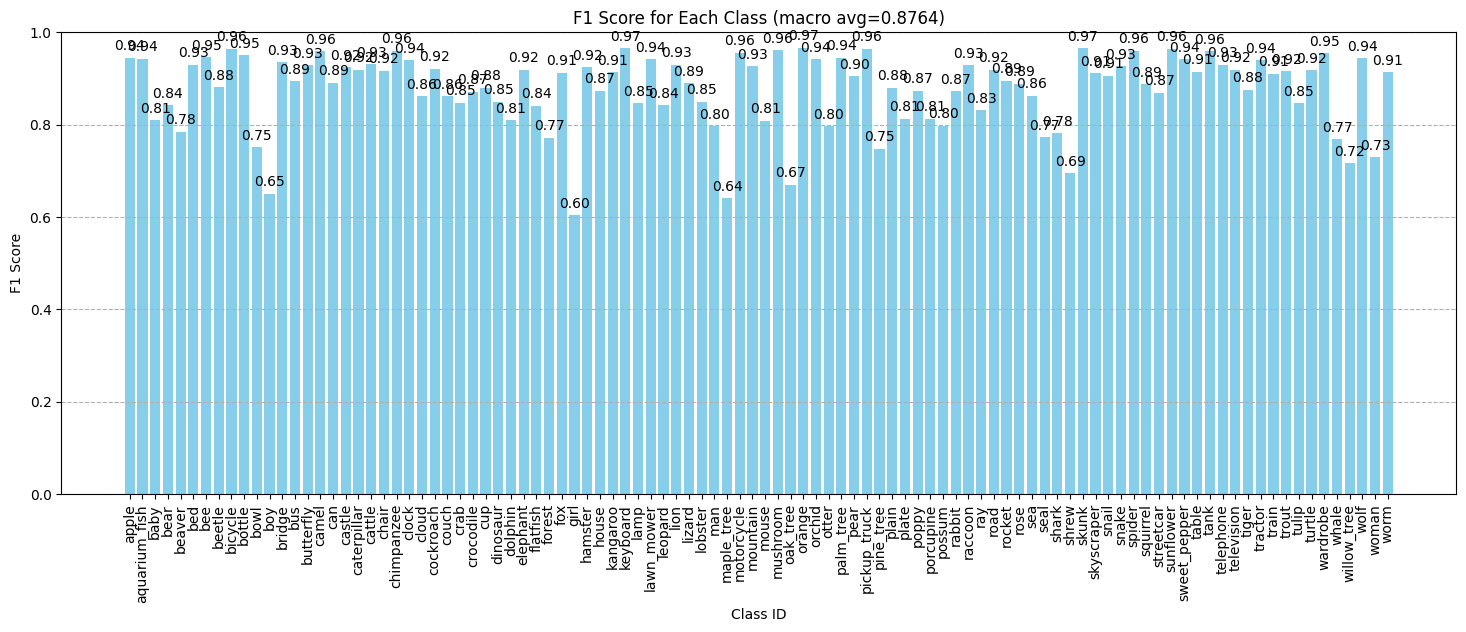

In [124]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=100)
model = model.to(device)
model.load_state_dict(torch.load("./cifar100_models/SmallViT_aug_wd_pcw_100ep.pt",weights_only=True))
calculate_f1_score_and_plot_torchmetrics(model,testloader,class_names)